### Bank Churn Prediction : Omar Elghaffouli x ATTIJARI WAFA

In [3]:
### import des librairies 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import shap 
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('dataset.csv', sep=';')
df.head(5)

,id_client,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,...,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,branche,churn
0,3463,H,0.0,non,non,37.0,oui,consommation,medium,oui,...,13545.535937,12243.785415,12140.590245,9013.777747,11604.261036,16390.415593,14631.204899,23988.305931,NORD-OUEST,non
1,1869,H,0.0,oui,oui,72.0,oui,consommation,premium,inconnu,...,14014.989673,15508.546834,17547.988381,15470.524076,17537.628474,17410.472648,21258.908987,21554.411100,NORD-OUEST,non
2,3760,H,0.0,non,non,3.0,oui,NaN,medium,non,...,17239.846026,19479.322456,21343.802381,24084.291026,25823.493343,25839.829752,25587.814976,29736.376226,NORD-OUEST,non
3,3820,H,1.0,oui,non,72.0,oui,consommation,medium,oui,...,9229.470887,11935.244779,11014.748509,11791.353542,16354.051367,15449.967495,21149.789933,29211.314803,NORD-OUEST,non
4,1463,F,0.0,non,non,4.0,oui,permanent,medium,non,...,9008.641700,5875.342745,6101.742525,8026.508871,10361.246523,10575.966610,6714.625315,9101.978017,NORD-OUEST,oui


In [5]:
### vérifier s'il y a des doublons d'échantillons dans le dataset
df.duplicated().sum()

0

In [6]:
### shape of the dataset (nbr de lignes, nbr de colones)
df.shape 

(7043, 63)

In [7]:
### information sur le dataset et les variables 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_client                     7043 non-null   int64  
 1   genre                         6915 non-null   object 
 2   espace_client_web             6916 non-null   float64
 3   assurance_vie                 6912 non-null   object 
 4   banque_principale             6921 non-null   object 
 5   anciennete_mois               6909 non-null   float64
 6   compte_epargne                6894 non-null   object 
 7   credit_autres                 6916 non-null   object 
 8   cartes_bancaires              6893 non-null   object 
 9   compte_courant                6896 non-null   object 
 10  espace_client                 6912 non-null   object 
 11  PEA                           6897 non-null   object 
 12  assurance_auto                6907 non-null   object 
 13  ass

### Analyse
* On remarque la présence des valeurs manquantes dans le dataset. 
* Dans une première étape, nous allons commencer par séparer les variables catégorielles et les variables continues pour faciliter le traitement du dataset.

In [8]:
### Récupérer la liste des variables catégorielles 
categorical_features = []       ### liste pour stocker le nom des variables catégorielles du dataset
for e in df.dtypes.index:
    if df.dtypes[e]==object:
        categorical_features.append(e)
categorical_features

['genre',
 'assurance_vie',
 'banque_principale',
 'compte_epargne',
 'credit_autres',
 'cartes_bancaires',
 'compte_courant',
 'espace_client',
 'PEA',
 'assurance_auto',
 'assurance_habitation',
 'credit_immo',
 'type',
 'compte_titres',
 'methode_contact',
 'interet_compte_epargne_total',
 'segment_client',
 'branche',
 'churn']

In [9]:
### vérifions si bien toute les variables stockées dans liste [categorical_features] sont catégorielles 
df[categorical_features].nunique()     ## le nombre de valeurs uniques que peut prendre chaque feature 

genre                              2
assurance_vie                      2
banque_principale                  2
compte_epargne                     2
credit_autres                      3
cartes_bancaires                   3
compte_courant                     3
espace_client                      3
PEA                                3
assurance_auto                     3
assurance_habitation               3
credit_immo                        3
type                               2
compte_titres                      2
methode_contact                    4
interet_compte_epargne_total    6411
segment_client                    15
branche                            6
churn                              2
dtype: int64

##### Analyse
* On remarque que le feature "interet_compte_epargne_total" contient plusieurs valeurs distinctes. Nous allons vérifier si ces valeurs sont continues ou catégorielles.

In [10]:
### display des valeurs de la colonne interet_compte_epargne_total
df['interet_compte_epargne_total'].values

array(['3369.25', '1734.65', '232.5', ..., '6687.85', '6145.85', '739.35'],
      dtype=object)

### Analyse
Il est clair que le feature 'interet_compte_epargne_total' peut prendre une infinité de valeurs. Néamoins, les valeurs sont renseignées en type str. Il faut donc convertir le type de la colonne en float. 

In [11]:
### covertir le type de la colonne en float
df['interet_compte_epargne_total']=pd.to_numeric(df['interet_compte_epargne_total'], errors='coerce') 

In [12]:
#Vérifions si d'autres feature ont un faux typing (int, float, etc,)
df.nunique().iloc[0:60]

id_client                       7043
genre                              2
espace_client_web                  2
assurance_vie                      2
banque_principale                  2
anciennete_mois                   73
compte_epargne                     2
credit_autres                      3
cartes_bancaires                   3
compte_courant                     3
espace_client                      3
PEA                                3
assurance_auto                     3
assurance_habitation               3
credit_immo                        3
type                               2
compte_titres                      2
methode_contact                    4
agios_6mois                     1577
interet_compte_epargne_total    6410
age                               88
segment_client                    15
var_0                           6893
var_1                           6905
var_2                           6885
var_3                           6896
var_4                           6905
v

In [13]:
df.nunique().iloc[60:63]

var_38     6888
branche       6
churn         2
dtype: int64

In [14]:
'espace_client_web' in categorical_features

False

### Analyse: 
* Le feature 'espace_client_web' ne prend que 3 valeurs dans le dataset mais ne figure parmi les variables catégorielles !

In [15]:
df['espace_client_web'].unique()    ### Le feature ne prend que deux valeurs ayant un type float. 

array([ 0.,  1., nan])

In [128]:
### Convertissons le type de la colonne
df['espace_client_web']=df['espace_client_web'].astype(str)

### Reexécutons la Récupération de  la liste des variables catégorielles 
categorical_features = []
for e in df.dtypes.index:
    if df.dtypes[e]==object:
        categorical_features.append(e)
categorical_features     ### liste définitif des variables catégorielles

['genre',
 'espace_client_web',
 'assurance_vie',
 'banque_principale',
 'compte_epargne',
 'credit_autres',
 'cartes_bancaires',
 'compte_courant',
 'espace_client',
 'PEA',
 'assurance_auto',
 'assurance_habitation',
 'credit_immo',
 'type',
 'compte_titres',
 'methode_contact',
 'segment_client',
 'branche',
 'churn']

In [17]:
num_categorical_features = len(categorical_features)
print(f'number_of_categorical_features : {num_categorical_features}')

number_of_categorical_features : 19


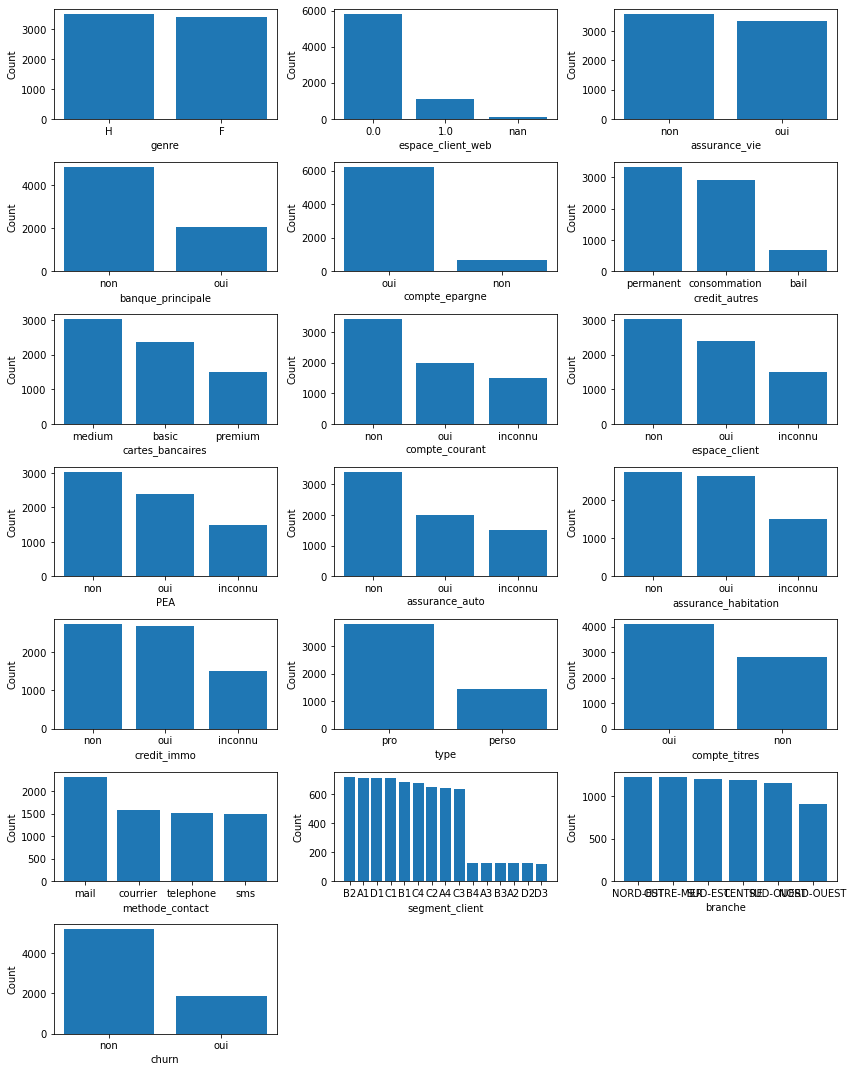

In [18]:
### Visualisation et Compréhension des valeurs catégorielles 
num_rows = num_categorical_features // 3 + (len(categorical_features) % 3 > 0) 
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 15))
axes = axes.flatten()
for i,e in enumerate(categorical_features):
    ax = axes[i]
    ax.bar(df[e].value_counts().index, df[e].value_counts())
    ax.set_xlabel(e)
    ax.set_ylabel('Count')

for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

### Analyse: 
* Le dataset n'est pas équilibré. Il y a environ 2000 churners contre plus que 4000 non-churners. 
* La banque compte des segments majoritaires (B2, A1, D1, C1, B1, C4, C2, A4, C3). Dans les segments restants, il y a peu de clients. Cela pourrait avoir un impact sur le churn. 
* Les clients de type pro sont les plus majoritaires. Il y a presque plus que 50% des clients pro par rapport aux clients de type 'perso'.
* presque 4/5 des clients de la banque n'ont pas un espace client web. 
* La majorité des clients de la banque détient un compte épargne.
* La banque étudiée n'est pas la banque principale de presque 1/2 de ses clients. 

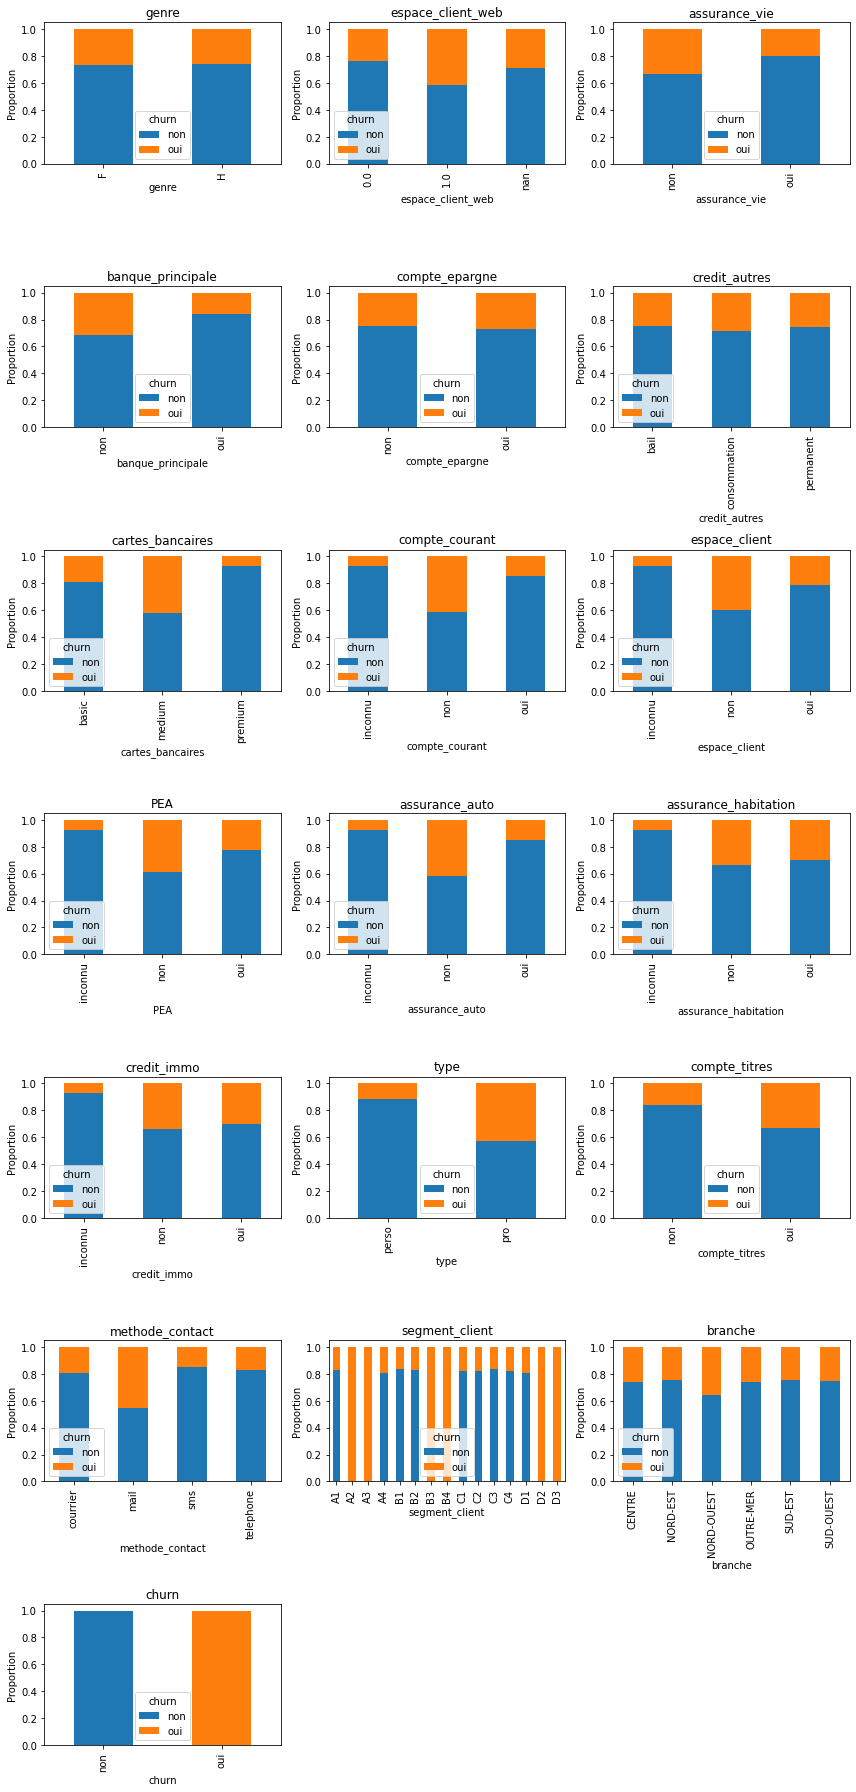

In [19]:
### maintenant on va plotter un stacked bar plot. 
### Il va nous permettre de comprendre la proportion des churners pour chaque catégorie de chaque variable
### Cela va nous aider à comparer les churners entre les catégories de chaque variable 
### Aussi d'avoir une vision préliminaire, juste à partir des visualisations, des patterns du churner
num_rows = num_categorical_features // 3 + (len(categorical_features) % 3 > 0) 
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 25))
axes = axes.flatten()
for i,e in enumerate(categorical_features):
    ax = axes[i]
    cross_tab = pd.crosstab(df[e], df['churn'], normalize='index')
    cross_tab.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(e)
    ax.set_ylabel('Proportion')
    
for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

### Analyse: 
    * Il y a beaucoup plus de churners dans branche Nord-Ouest de la banque. 
    * Dans les segments client minoritaires de la banque, il y a 100% des churners. 
    * Les clients contactés par mail sont ceux qui churnent le plus. 
    * 50% des clients pro sont des churners alors qu'ils sont plus les pricipaux clients de la banque.   

### Comment alors expliquer cela ? 
* Commençons par analyser les clients pro. Quelles sont les facteurs expliquant un taux de churn élevé pour ce segment. 

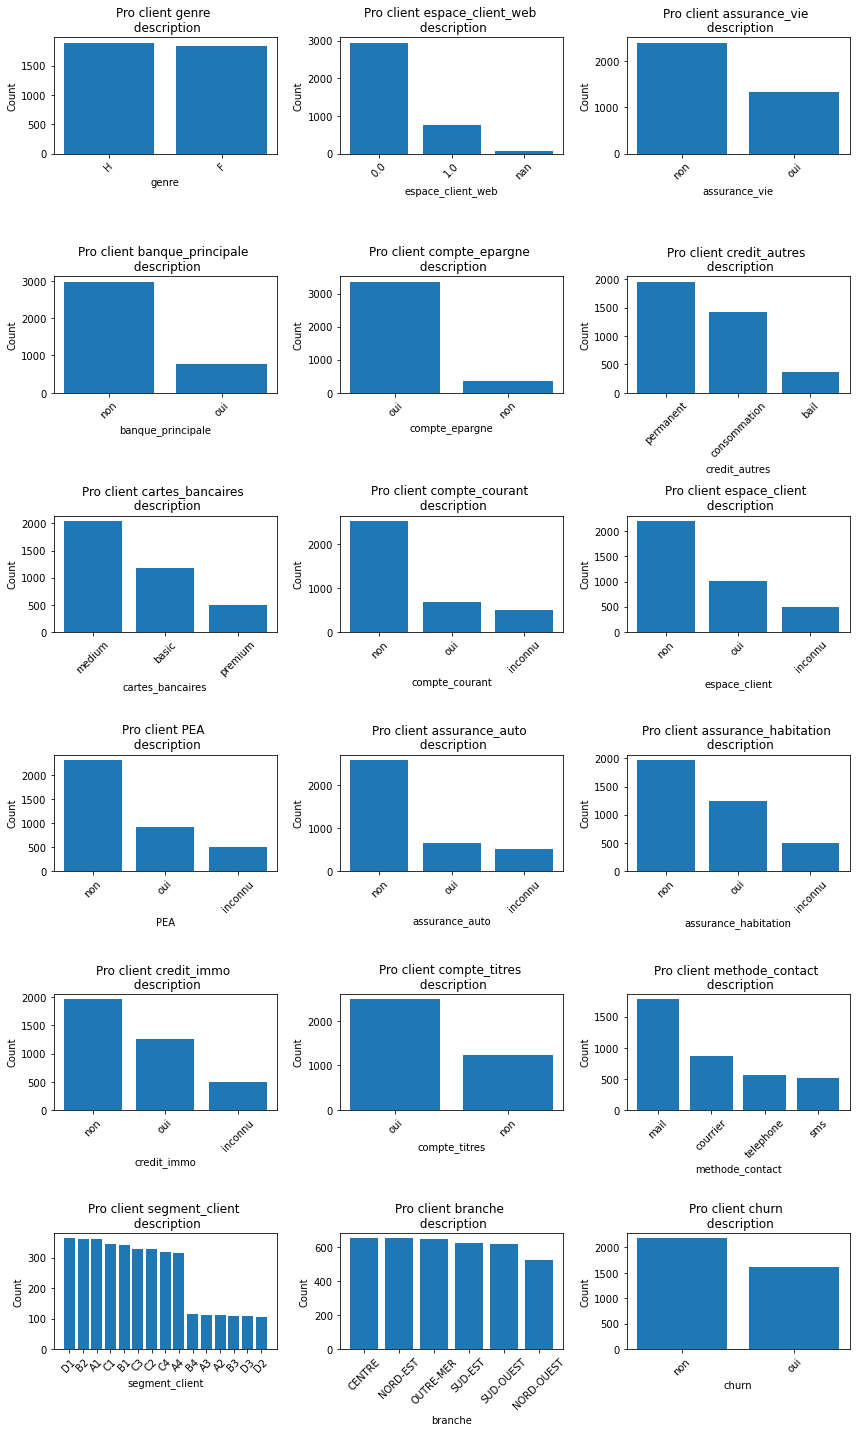

In [20]:
### Començons par analyser les clinets pro. Quelles sont les facteurs expliquant un taux de churn élevé pour ce segment. 
df_cat_pro = df[categorical_features][df['type'] == 'pro']
cat_features_type_excluded = categorical_features.copy()
cat_features_type_excluded.remove('type')
num_rows = len(cat_features_type_excluded) // 3 + (len(cat_features_type_excluded) % 3 > 0) 
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 20))
axes = axes.flatten()
for i,e in enumerate(cat_features_type_excluded):
    ax = axes[i]
    
    
    ax.bar(df_cat_pro[e].value_counts().index, df_cat_pro[e].value_counts())
    ax.set_xticklabels(df_cat_pro[e].value_counts().index, rotation=45)
    ax.set_xlabel(e)
    ax.set_ylabel('Count')
    ax.set_title(f'Pro client {e} \n description')

for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

### Analyse:
* les clients contacté par mail ont un taux de churn élevé. Les clients de type pro sont contacté souvent par mail. 
* La plupart des clients pro dispose de compte_titre. D'après le graphe précédent, ceux qui disposent de compte titre ont un taux de churn élevé.
* la plupart des clients pro n'ont pas une assurance auto, PEA, d'espace client, compte courant, banque principale. 
* les clients pro disposent généralement d'une carte médium. 

#### Pourquoi il y a un taux de churn élevé pour les segments A2, A3, B3, B4, D2, D3

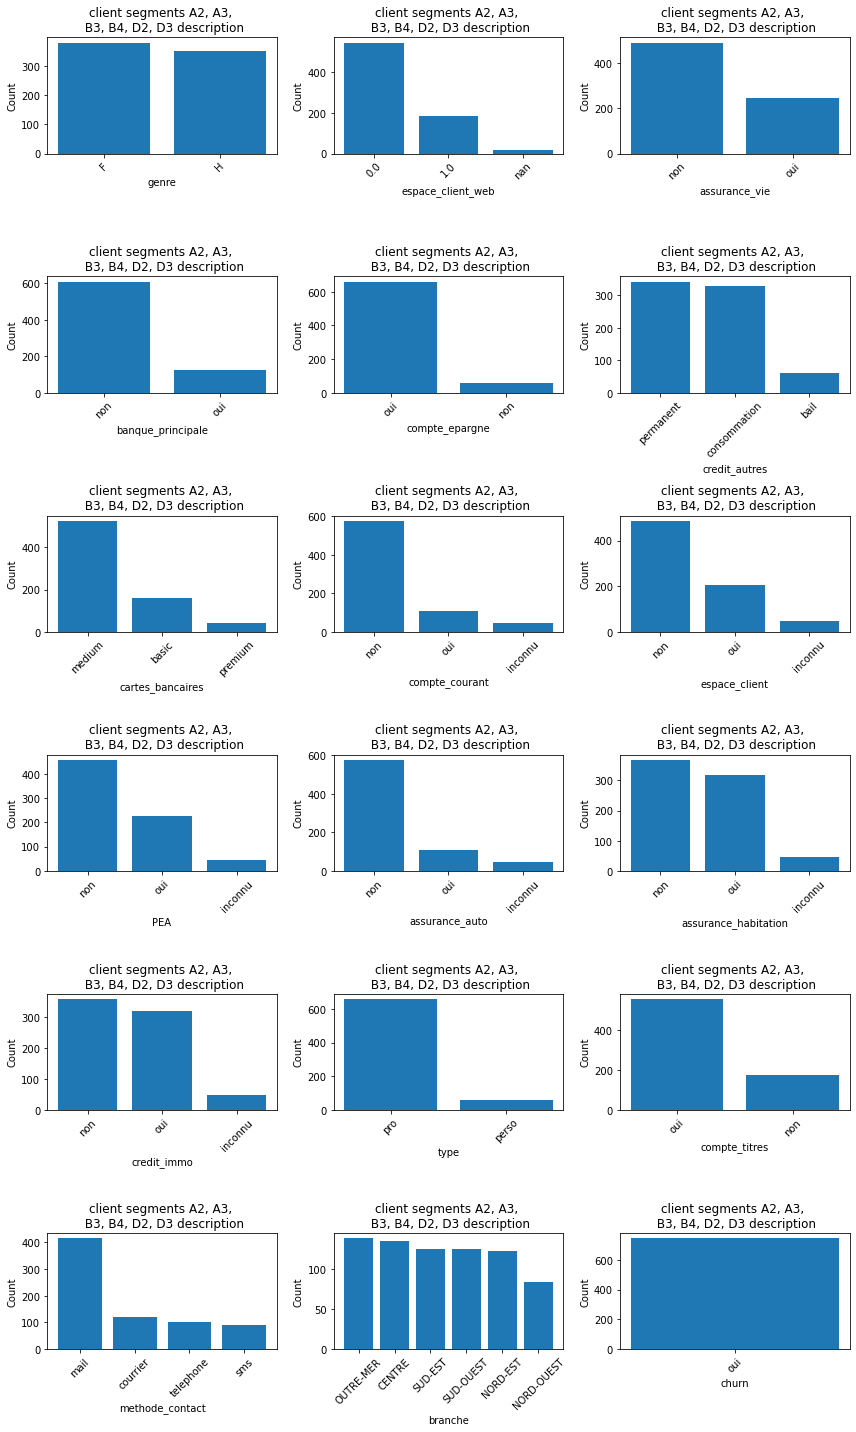

In [21]:
df_cat_segment = df[categorical_features][(df['segment_client'] == 'A2')|(df['segment_client']== 'A3')|(df['segment_client']== 'B3')| 
                                      (df['segment_client']=='B4')|(df['segment_client']== 'D2')|(df['segment_client']== 'D3')]
cat_features_segment_excluded = categorical_features.copy()
cat_features_segment_excluded.remove('segment_client')
num_rows = len(cat_features_segment_excluded) // 3 + (len(cat_features_segment_excluded) % 3 > 0) 
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 20))
axes = axes.flatten()
for i,e in enumerate(cat_features_segment_excluded):
    ax = axes[i]
    ax.bar(df_cat_segment[e].value_counts().index, df_cat_segment[e].value_counts())
    ax.set_xticklabels(df_cat_segment[e].value_counts().index, rotation=45)
    ax.set_xlabel(e)
    ax.set_ylabel('Count')
    ax.set_title(f'client segments A2, A3, \n B3, B4, D2, D3 description')

for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

### Analyse: 
    * méthode de contact par mail
    * presque les mêmes raison que l'analyse précédente. 

### Pourquoi dans la branche Nord-ouest il y a un taux de churn élevé ? 

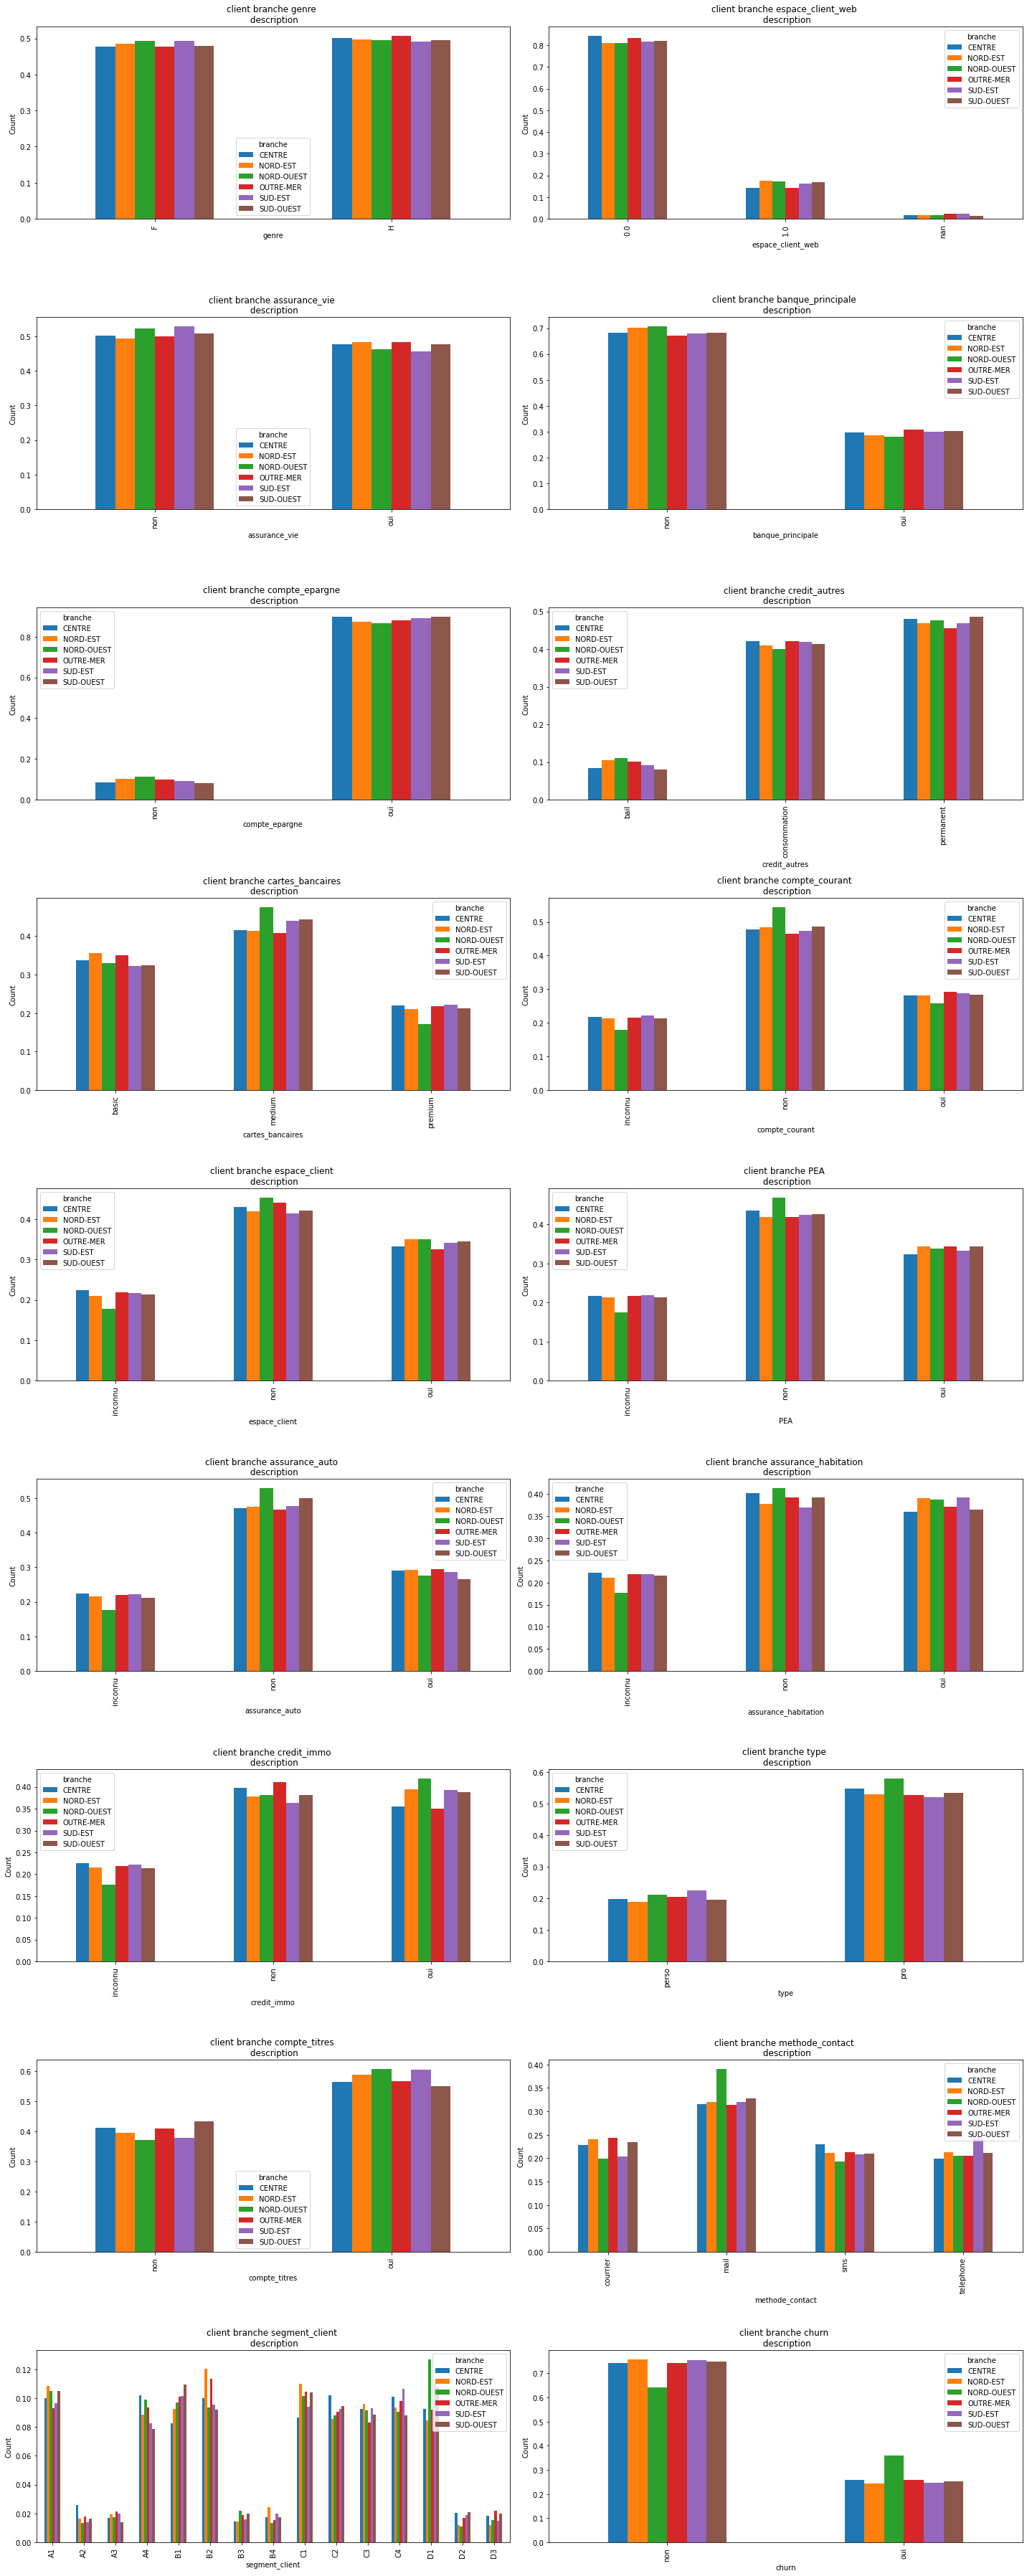

In [22]:
df_cat_branche = df[categorical_features]
cat_features_branche_excluded = categorical_features.copy()
cat_features_branche_excluded.remove('branche')
fig, axes = plt.subplots(9, 2, figsize=(20, 50))
axes = axes.flatten()
for i,e in enumerate(cat_features_branche_excluded):
    ax = axes[i]
    total_counts = df_cat_branche.groupby('branche').size()
    counts = df_cat_branche.groupby([e, 'branche']).size().unstack()
    normalized_counts = counts.div(total_counts, axis=1)
    normalized_counts.plot(kind='bar', stacked=False, ax =ax)
    ax.set_xlabel(e)
    ax.set_ylabel('Count')
    ax.set_title(f'client branche {e} \n description')

for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

### Analyse: pourquoi la branche nord ouest à un taux de churn élevé ?
* Dans cette branche, il y a beaucoup plus du segment B3 par rapport aux autres.
* On utilise une méthode contact par mail beaucoup plus par rapport aux autres branches. 
* La raison principale est que dans cette  branche, il y a le plus grand nombre de clients de types pro qui ont tendance à churner pour des facteurs expliquées en haut. 

In [23]:
### Analysons et comprenons maintenant les variables continues
continuous_features = []
for e in df.dtypes.index:
    if df.dtypes[e]==float:
        continuous_features.append(e)
continuous_features

['anciennete_mois',
 'agios_6mois',
 'interet_compte_epargne_total',
 'age',
 'var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38']

In [24]:
num_continuous_features = len(continuous_features)
print(f'number_of_continuous_features : {num_continuous_features}')

number_of_continuous_features : 43


<AxesSubplot:xlabel='churn', ylabel='var_1'>

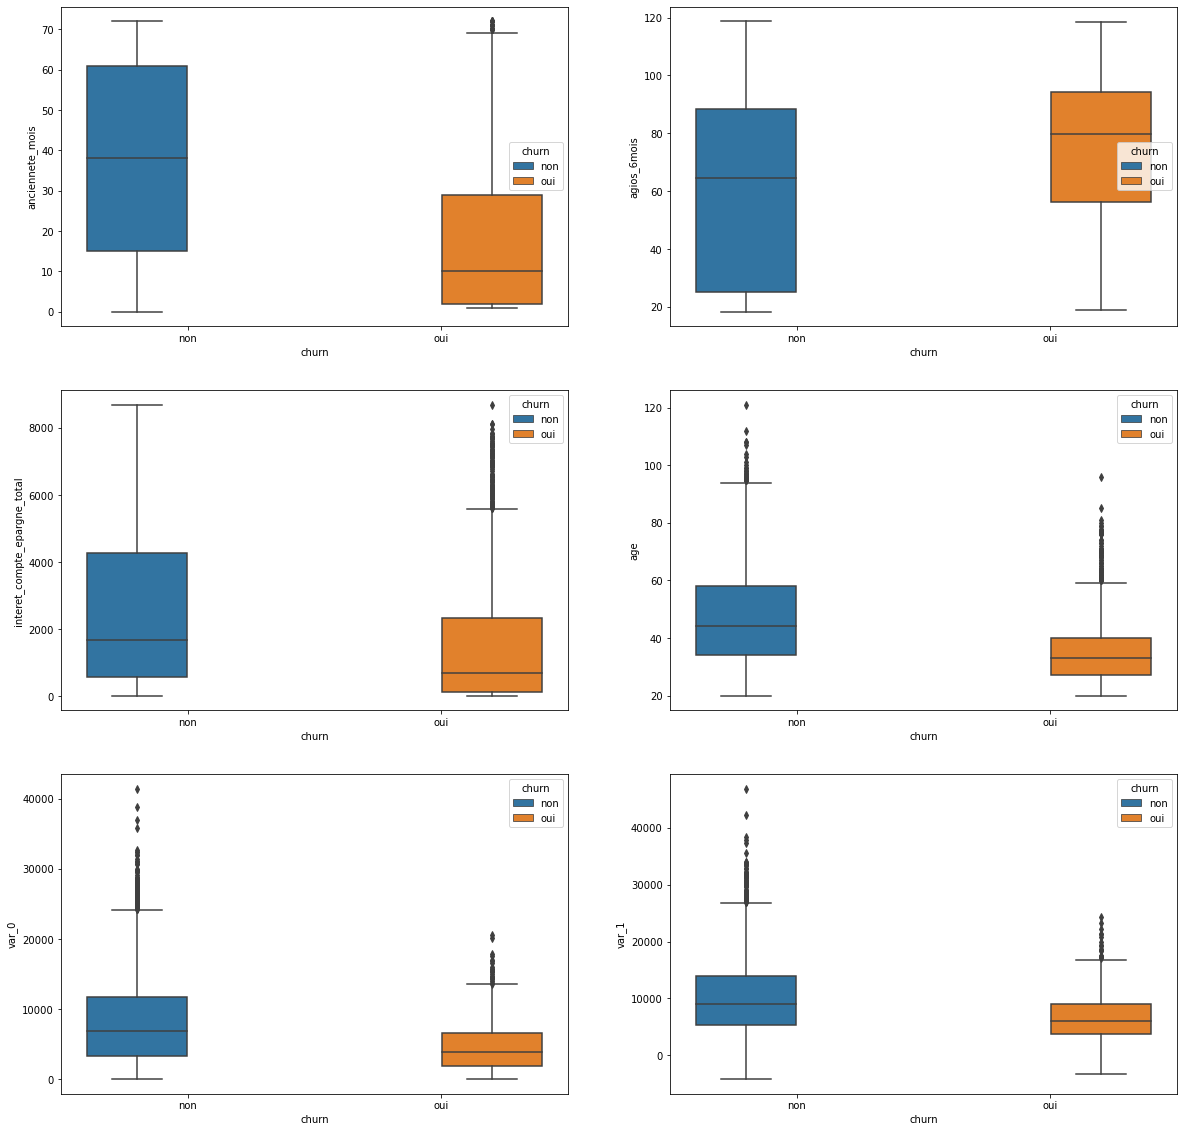

In [25]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
data = pd.concat((df[continuous_features], df.churn), axis=1)
sns.boxplot(y='anciennete_mois',x = 'churn', hue = 'churn',data = data, ax=axarr[0][0])
sns.boxplot(y='agios_6mois',x = 'churn', hue = 'churn',data = data, ax=axarr[0][1])
sns.boxplot(y='interet_compte_epargne_total',x = 'churn', hue = 'churn',data = data, ax=axarr[1][0])
sns.boxplot(y='age',x = 'churn', hue = 'churn',data = data, ax=axarr[1][1])
sns.boxplot(y='var_0',x = 'churn', hue = 'churn',data = data, ax=axarr[2][0])
sns.boxplot(y='var_1',x = 'churn', hue = 'churn',data = data, ax=axarr[2][1])

### Analyse: 
* plus l'ancieneté des clients est élevée, plus il est moins probable qu'il churn. 50% des churners ont une ancienneté - de 10 mois
* les clients jeunes ( moins de 35 ans) ont tendance à churner. 

<AxesSubplot:xlabel='churn', ylabel='var_7'>

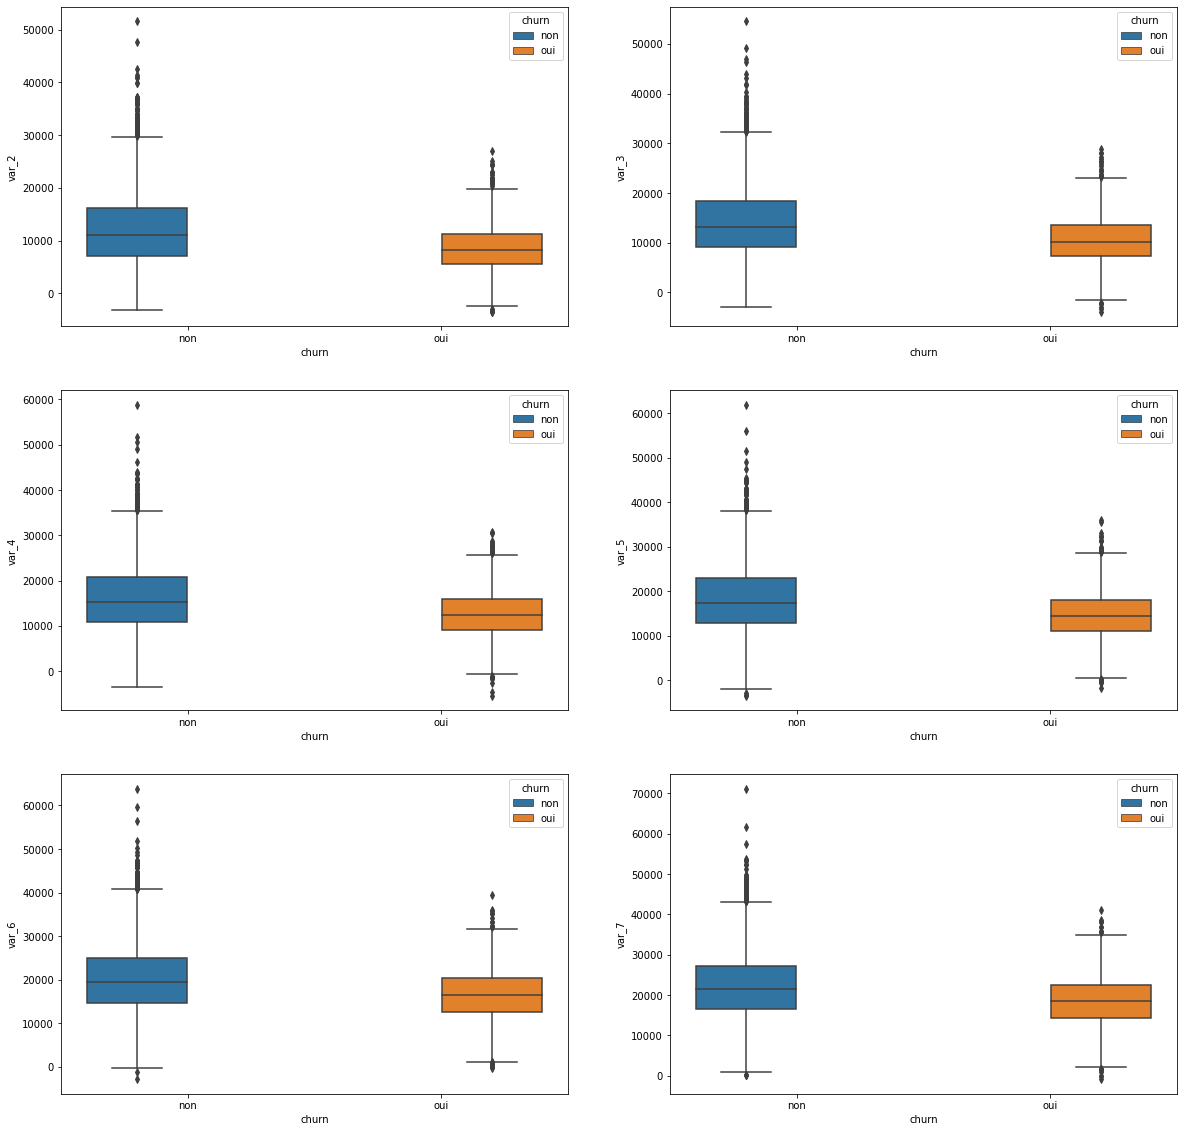

In [26]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
sns.boxplot(y='var_2',x = 'churn', hue = 'churn',data = data, ax=axarr[0][0])
sns.boxplot(y='var_3',x = 'churn', hue = 'churn',data = data, ax=axarr[0][1])
sns.boxplot(y='var_4',x = 'churn', hue = 'churn',data = data, ax=axarr[1][0])
sns.boxplot(y='var_5',x = 'churn', hue = 'churn',data = data, ax=axarr[1][1])
sns.boxplot(y='var_6',x = 'churn', hue = 'churn',data = data, ax=axarr[2][0])
sns.boxplot(y='var_7',x = 'churn', hue = 'churn',data = data, ax=axarr[2][1])

<AxesSubplot:xlabel='churn', ylabel='var_13'>

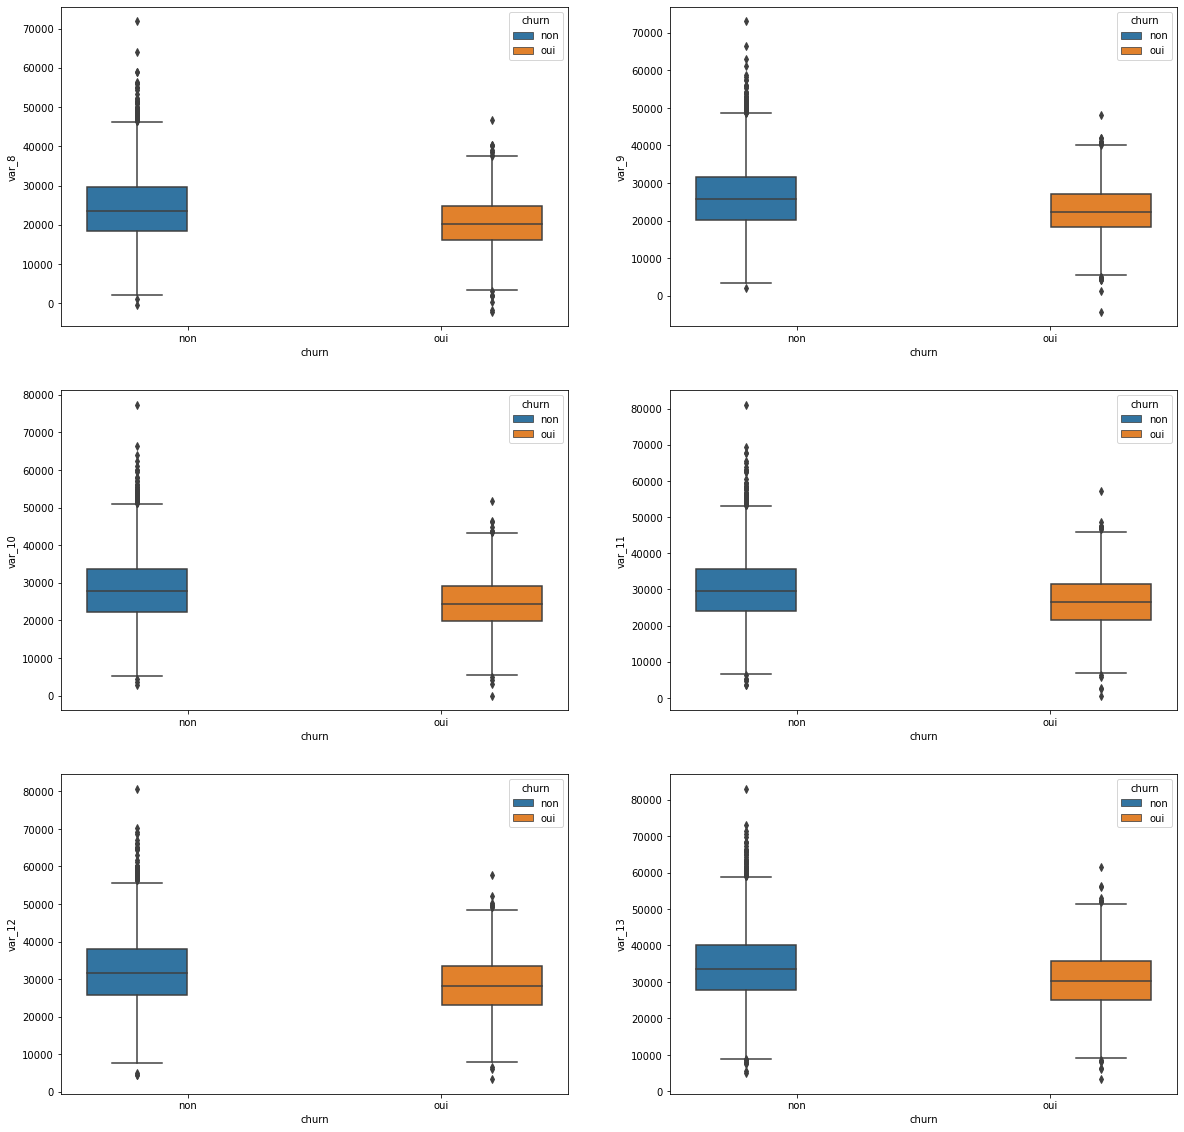

In [27]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
sns.boxplot(y='var_8',x = 'churn', hue = 'churn',data = data, ax=axarr[0][0])
sns.boxplot(y='var_9',x = 'churn', hue = 'churn',data = data, ax=axarr[0][1])
sns.boxplot(y='var_10',x = 'churn', hue = 'churn',data = data, ax=axarr[1][0])
sns.boxplot(y='var_11',x = 'churn', hue = 'churn',data = data, ax=axarr[1][1])
sns.boxplot(y='var_12',x = 'churn', hue = 'churn',data = data, ax=axarr[2][0])
sns.boxplot(y='var_13',x = 'churn', hue = 'churn',data = data, ax=axarr[2][1])

<AxesSubplot:xlabel='churn', ylabel='var_19'>

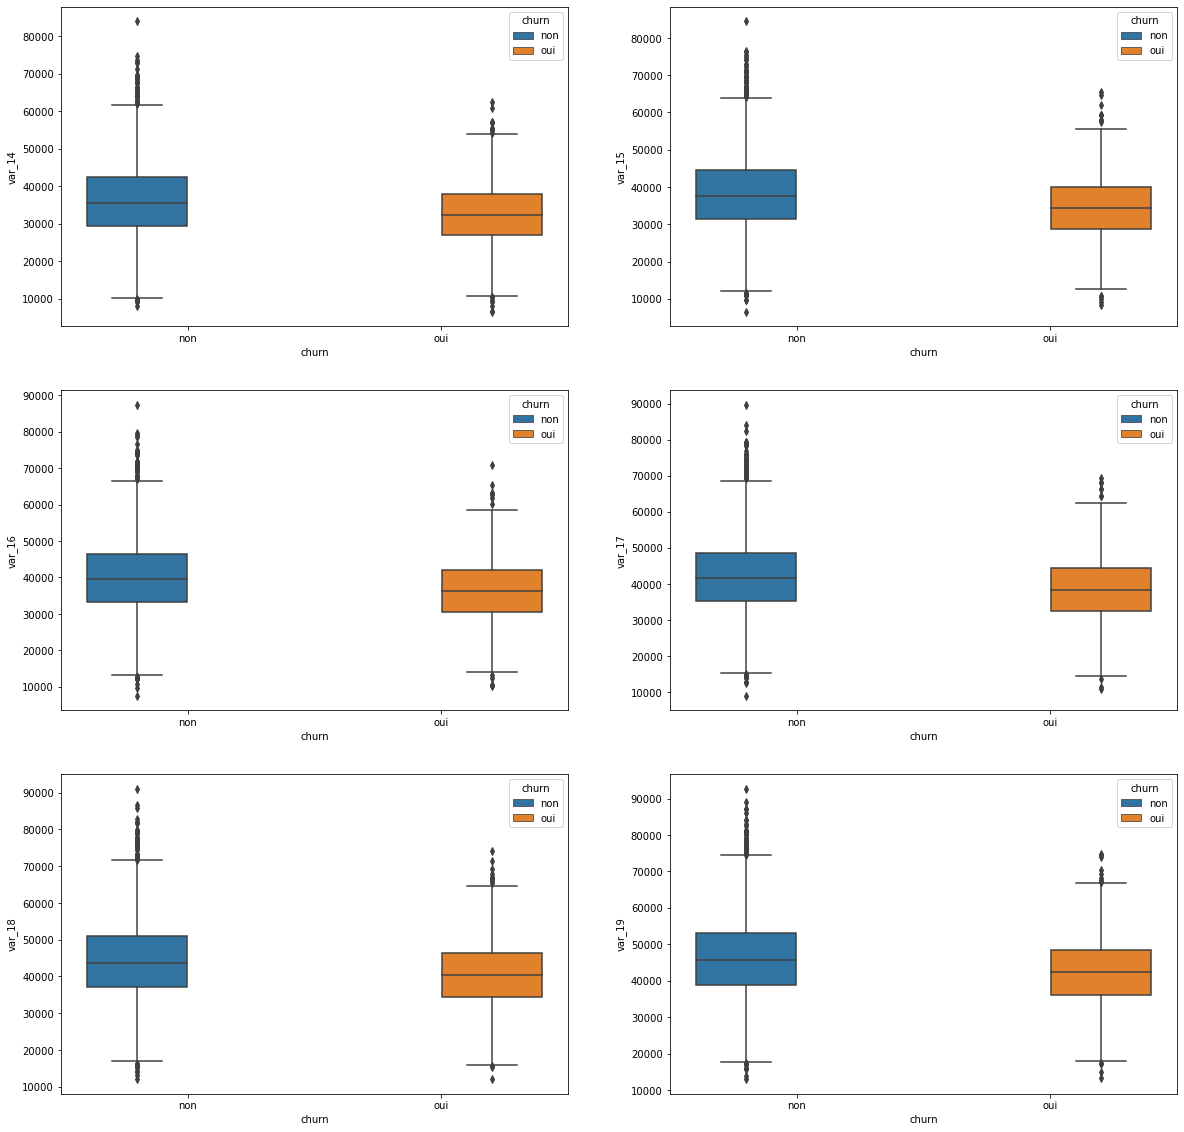

In [28]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
sns.boxplot(y='var_14',x = 'churn', hue = 'churn',data = data, ax=axarr[0][0])
sns.boxplot(y='var_15',x = 'churn', hue = 'churn',data = data, ax=axarr[0][1])
sns.boxplot(y='var_16',x = 'churn', hue = 'churn',data = data, ax=axarr[1][0])
sns.boxplot(y='var_17',x = 'churn', hue = 'churn',data = data, ax=axarr[1][1])
sns.boxplot(y='var_18',x = 'churn', hue = 'churn',data = data, ax=axarr[2][0])
sns.boxplot(y='var_19',x = 'churn', hue = 'churn',data = data, ax=axarr[2][1])

<AxesSubplot:xlabel='churn', ylabel='var_25'>

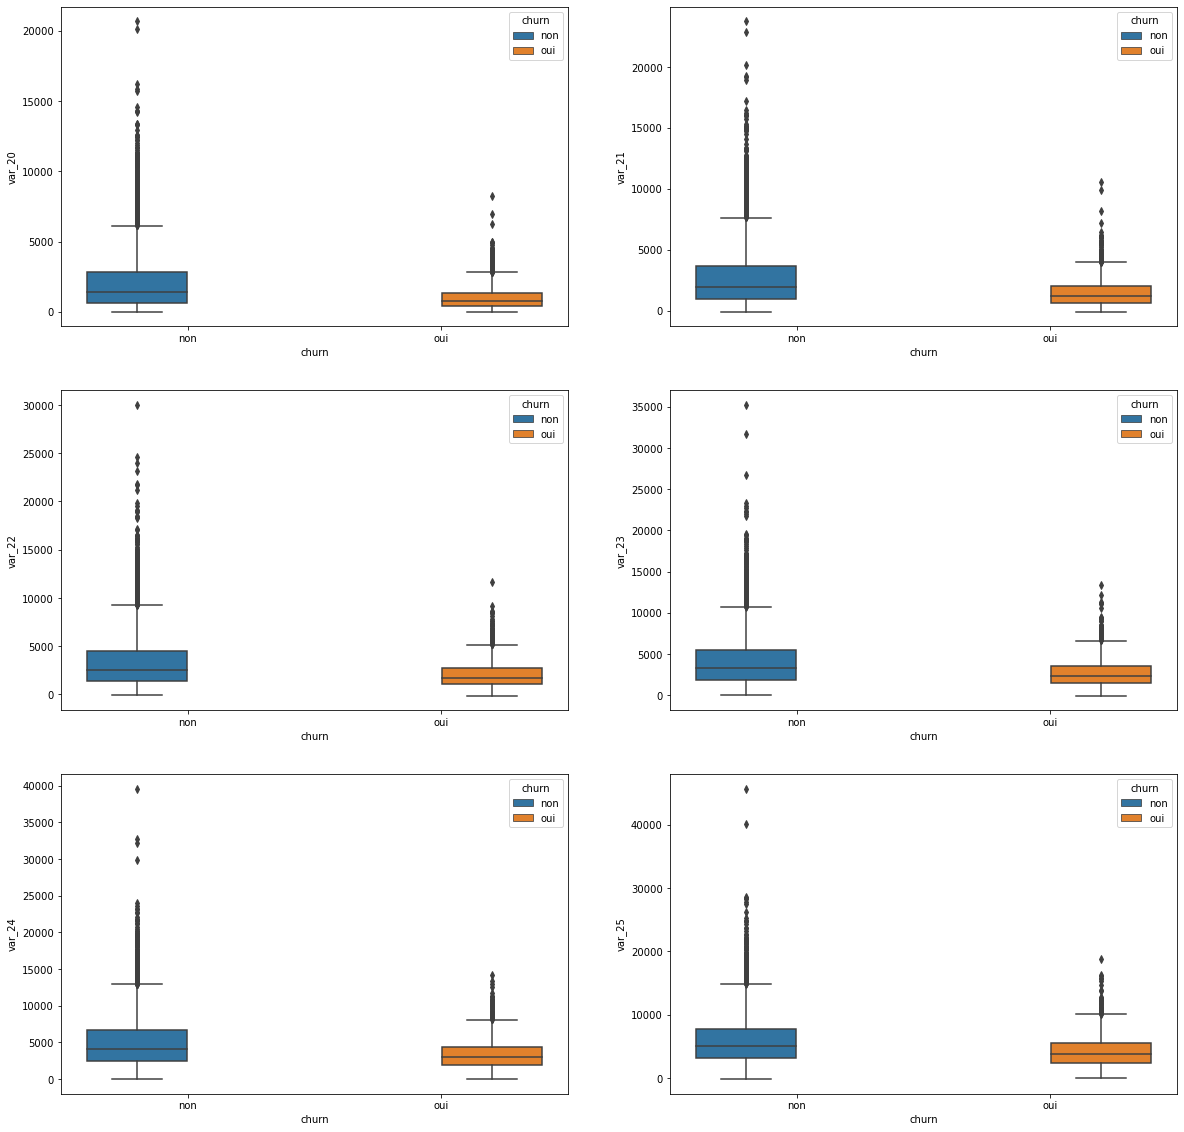

In [29]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
sns.boxplot(y='var_20',x = 'churn', hue = 'churn',data = data, ax=axarr[0][0])
sns.boxplot(y='var_21',x = 'churn', hue = 'churn',data = data, ax=axarr[0][1])
sns.boxplot(y='var_22',x = 'churn', hue = 'churn',data = data, ax=axarr[1][0])
sns.boxplot(y='var_23',x = 'churn', hue = 'churn',data = data, ax=axarr[1][1])
sns.boxplot(y='var_24',x = 'churn', hue = 'churn',data = data, ax=axarr[2][0])
sns.boxplot(y='var_25',x = 'churn', hue = 'churn',data = data, ax=axarr[2][1])

<AxesSubplot:xlabel='churn', ylabel='var_31'>

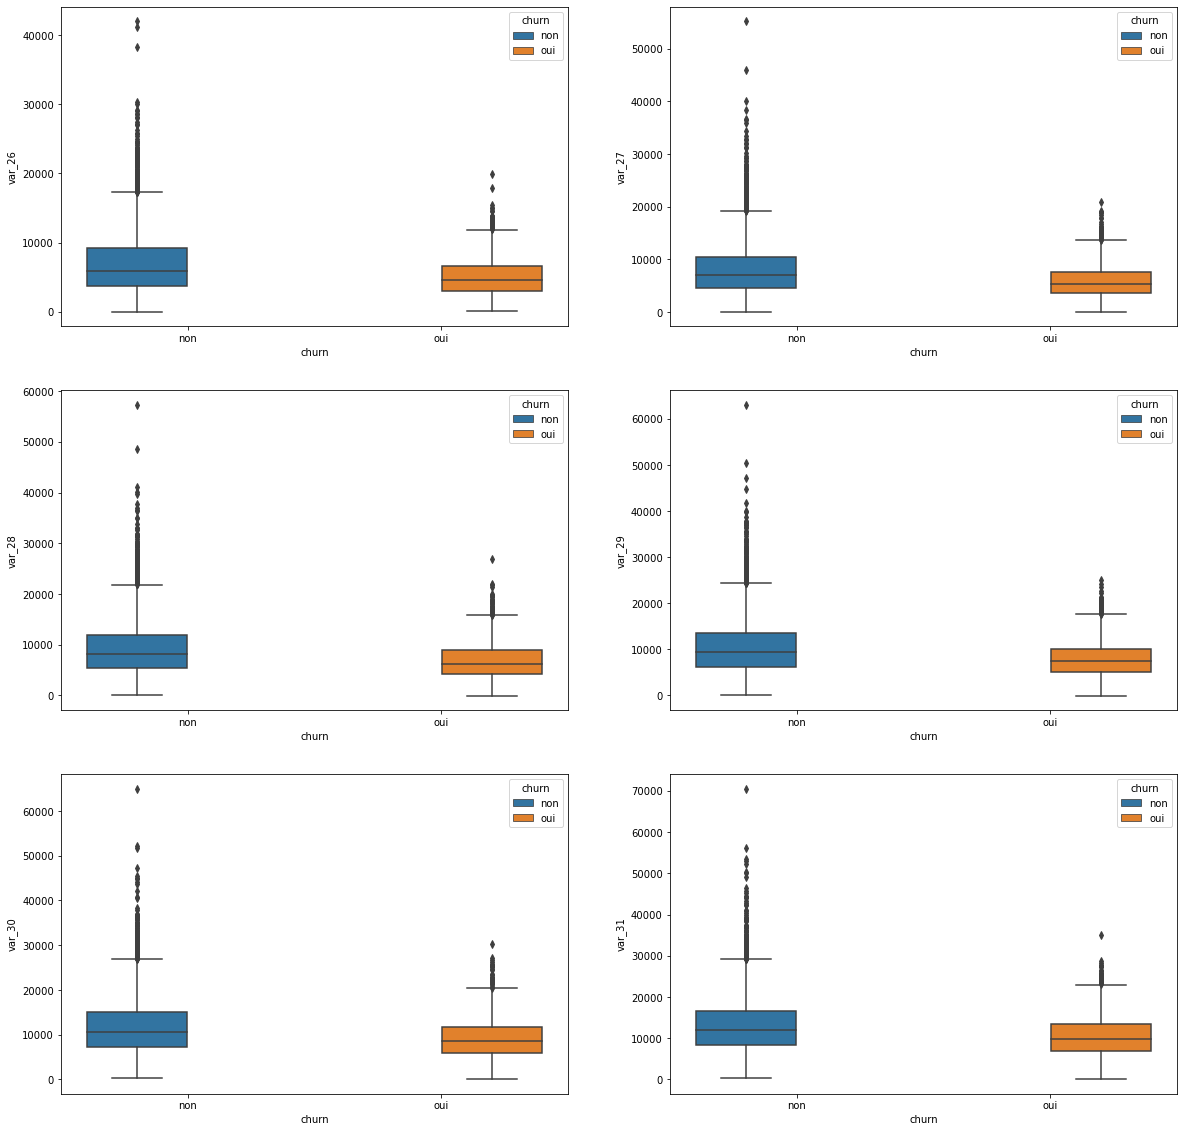

In [30]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
sns.boxplot(y='var_26',x = 'churn', hue = 'churn',data = data, ax=axarr[0][0])
sns.boxplot(y='var_27',x = 'churn', hue = 'churn',data = data, ax=axarr[0][1])
sns.boxplot(y='var_28',x = 'churn', hue = 'churn',data = data, ax=axarr[1][0])
sns.boxplot(y='var_29',x = 'churn', hue = 'churn',data = data, ax=axarr[1][1])
sns.boxplot(y='var_30',x = 'churn', hue = 'churn',data = data, ax=axarr[2][0])
sns.boxplot(y='var_31',x = 'churn', hue = 'churn',data = data, ax=axarr[2][1])


<AxesSubplot:xlabel='churn', ylabel='var_37'>

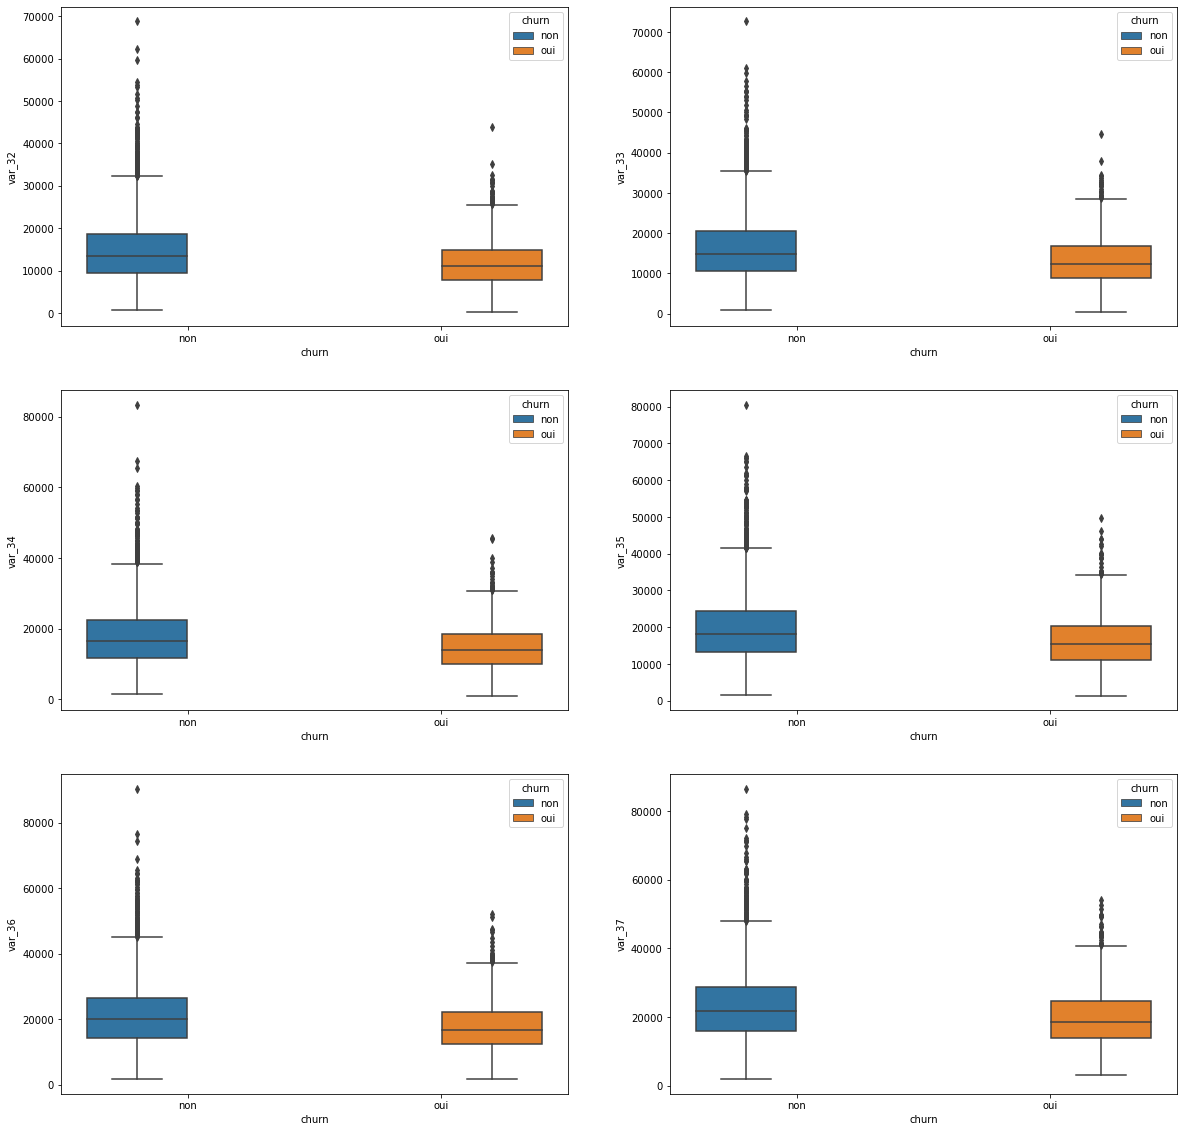

In [31]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 20))
sns.boxplot(y='var_32',x = 'churn', hue = 'churn',data = data, ax=axarr[0][0])
sns.boxplot(y='var_33',x = 'churn', hue = 'churn',data = data, ax=axarr[0][1])
sns.boxplot(y='var_34',x = 'churn', hue = 'churn',data = data, ax=axarr[1][0])
sns.boxplot(y='var_35',x = 'churn', hue = 'churn',data = data, ax=axarr[1][1])
sns.boxplot(y='var_36',x = 'churn', hue = 'churn',data = data, ax=axarr[2][0])
sns.boxplot(y='var_37',x = 'churn', hue = 'churn',data = data, ax=axarr[2][1])

<AxesSubplot:xlabel='churn', ylabel='var_38'>

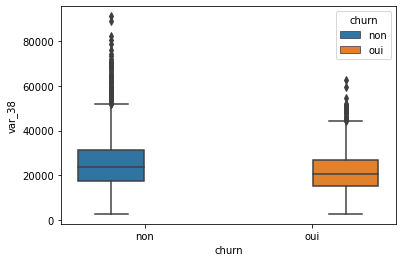

In [32]:
sns.boxplot(y='var_38',x = 'churn', hue = 'churn',data = data)

### Analyse des valeurs manquantes 

#### Analyse des valeurs manquantes dans les variables continues 

In [33]:
### nombre de valeurs manquantes par colonne 
df[continuous_features].isnull().sum()

anciennete_mois                 134
agios_6mois                     147
interet_compte_epargne_total    141
age                             154
var_0                           150
var_1                           138
var_2                           158
var_3                           147
var_4                           138
var_5                           142
var_6                           126
var_7                           136
var_8                           126
var_9                           139
var_10                          137
var_11                          134
var_12                          129
var_13                          134
var_14                          153
var_15                          161
var_16                          150
var_17                          120
var_18                          173
var_19                          139
var_20                          143
var_21                          138
var_22                          150
var_23                      

In [34]:
total_null_in_continuous_variables = df[continuous_features].isnull().sum().sum()
total_null_in_continuous_variables

6128

In [35]:
### what if we delete rows containing null values ?
number_of_lost_rows = df.shape[0]-df[continuous_features].dropna().shape[0]
number_of_lost_rows

4130

#### Analyse : 
* Deleting Rows containing null values implies a considerable loss of information. About 4130 rows will be lost. More than the half of our data.

In [36]:
corr_matrix = df[continuous_features].corr().abs()
corr_matrix

,anciennete_mois,agios_6mois,interet_compte_epargne_total,age,var_0,var_1,var_2,var_3,var_4,var_5,...,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38
anciennete_mois,1.000000,0.248049,0.825694,0.115301,0.094931,0.091862,0.083233,0.080782,0.081813,0.078020,...,0.078645,0.069341,0.063486,0.070477,0.065811,0.059823,0.059916,0.056196,0.052982,0.053379
agios_6mois,0.248049,1.000000,0.653055,0.047652,0.042255,0.039620,0.043967,0.040192,0.040129,0.043469,...,0.032184,0.034502,0.039396,0.029636,0.027327,0.033761,0.032788,0.032237,0.034894,0.033437
interet_compte_epargne_total,0.825694,0.653055,1.000000,0.069408,0.055622,0.051730,0.041266,0.039135,0.040739,0.035643,...,0.040507,0.031564,0.026124,0.031130,0.030935,0.024430,0.021234,0.021156,0.015678,0.018902
age,0.115301,0.047652,0.069408,1.000000,0.101858,0.095678,0.087549,0.085600,0.080708,0.082395,...,0.071155,0.064792,0.064584,0.056804,0.053981,0.058408,0.055740,0.051851,0.046745,0.048772
var_0,0.094931,0.042255,0.055622,0.101858,1.000000,0.946395,0.901050,0.861757,0.823675,0.794062,...,0.697392,0.682260,0.667666,0.648736,0.640486,0.617165,0.610094,0.591431,0.580434,0.567972
var_1,0.091862,0.039620,0.051730,0.095678,0.946395,1.000000,0.950485,0.909676,0.870884,0.838371,...,0.729887,0.716178,0.696624,0.680309,0.669788,0.649880,0.641398,0.621577,0.613165,0.600124
var_2,0.083233,0.043967,0.041266,0.087549,0.901050,0.950485,1.000000,0.956341,0.917160,0.882031,...,0.763288,0.749603,0.728411,0.710070,0.699640,0.682083,0.674052,0.652332,0.643013,0.630336
var_3,0.080782,0.040192,0.039135,0.085600,0.861757,0.909676,0.956341,1.000000,0.960176,0.923195,...,0.794205,0.778668,0.756835,0.739922,0.725711,0.708528,0.698288,0.680525,0.669134,0.655165
var_4,0.081813,0.040129,0.040739,0.080708,0.823675,0.870884,0.917160,0.960176,1.000000,0.962358,...,0.820692,0.803566,0.781478,0.762855,0.749465,0.730734,0.719826,0.701234,0.691486,0.677664
var_5,0.078020,0.043469,0.035643,0.082395,0.794062,0.838371,0.882031,0.923195,0.962358,1.000000,...,0.848065,0.832679,0.810611,0.791894,0.778248,0.759462,0.747966,0.729418,0.717873,0.704875


### Analyse:
* la plupart des variables continues sont fortement corrélées. On va supprimer les doublons en terme de corrélation forte avec d'autres variables  pour faciliter le traitement des valeurs manquantes par imputation.  

In [37]:
### select variables to delet that have a correlation  pair variable >0.9
var_corr_matrix = corr_matrix.iloc[4:,4:]
to_delete = []
for feature in var_corr_matrix.index:
    if var_corr_matrix[feature].sort_values(ascending=False).iloc[1] > 0.9:
        to_delete.append(feature)
        var_corr_matrix.drop(feature, axis=1, inplace=True)
        var_corr_matrix.drop(feature, axis=0, inplace=True)
to_delete

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37']

In [39]:
to_delete.remove('var_7')
to_delete.remove('var_8')
to_delete.remove('var_27')
to_delete.remove('var_28')
to_delete.remove('var_29')

In [40]:
df[continuous_features].drop(to_delete, axis=1).corr().abs()

,anciennete_mois,agios_6mois,interet_compte_epargne_total,age,var_7,var_8,var_20,var_21,var_22,var_27,var_28,var_29,var_38
anciennete_mois,1.000000,0.248049,0.825694,0.115301,0.079932,0.073557,0.090409,0.088984,0.078510,0.080263,0.076962,0.078645,0.053379
agios_6mois,0.248049,1.000000,0.653055,0.047652,0.040901,0.036068,0.040126,0.035081,0.032895,0.038395,0.037464,0.032184,0.033437
interet_compte_epargne_total,0.825694,0.653055,1.000000,0.069408,0.039493,0.035588,0.051127,0.053487,0.044797,0.044816,0.041881,0.040507,0.018902
age,0.115301,0.047652,0.069408,1.000000,0.081089,0.076350,0.081767,0.085973,0.079547,0.074160,0.079527,0.071155,0.048772
var_7,0.079932,0.040901,0.039493,0.081089,1.000000,0.968351,0.688042,0.726757,0.765937,0.947130,0.924945,0.900761,0.751854
var_8,0.073557,0.036068,0.035588,0.076350,0.968351,1.000000,0.668248,0.705294,0.743261,0.916407,0.951565,0.927285,0.776002
var_20,0.090409,0.040126,0.051127,0.081767,0.688042,0.668248,1.000000,0.885656,0.853533,0.718294,0.699160,0.675239,0.538133
var_21,0.088984,0.035081,0.053487,0.085973,0.726757,0.705294,0.885656,1.000000,0.894267,0.752728,0.734480,0.708676,0.571814
var_22,0.078510,0.032895,0.044797,0.079547,0.765937,0.743261,0.853533,0.894267,1.000000,0.789562,0.767837,0.743418,0.603244
var_27,0.080263,0.038395,0.044816,0.074160,0.947130,0.916407,0.718294,0.752728,0.789562,1.000000,0.916427,0.890160,0.730001


### Analyse: 
It turns that variables var_8, var_27, var_28, var_29 are strongly correlated with var_7

In [41]:
to_delete.append('var_8')
to_delete.append('var_27')
to_delete.append('var_28')
to_delete.append('var_29')

In [42]:
df[continuous_features].drop(to_delete, axis=1).corr().abs()

,anciennete_mois,agios_6mois,interet_compte_epargne_total,age,var_7,var_20,var_21,var_22,var_38
anciennete_mois,1.000000,0.248049,0.825694,0.115301,0.079932,0.090409,0.088984,0.078510,0.053379
agios_6mois,0.248049,1.000000,0.653055,0.047652,0.040901,0.040126,0.035081,0.032895,0.033437
interet_compte_epargne_total,0.825694,0.653055,1.000000,0.069408,0.039493,0.051127,0.053487,0.044797,0.018902
age,0.115301,0.047652,0.069408,1.000000,0.081089,0.081767,0.085973,0.079547,0.048772
var_7,0.079932,0.040901,0.039493,0.081089,1.000000,0.688042,0.726757,0.765937,0.751854
var_20,0.090409,0.040126,0.051127,0.081767,0.688042,1.000000,0.885656,0.853533,0.538133
var_21,0.088984,0.035081,0.053487,0.085973,0.726757,0.885656,1.000000,0.894267,0.571814
var_22,0.078510,0.032895,0.044797,0.079547,0.765937,0.853533,0.894267,1.000000,0.603244
var_38,0.053379,0.033437,0.018902,0.048772,0.751854,0.538133,0.571814,0.603244,1.000000


##### Analysons les corrélations restantes qui sont supérieurs à 0.7 (strong corrélations)

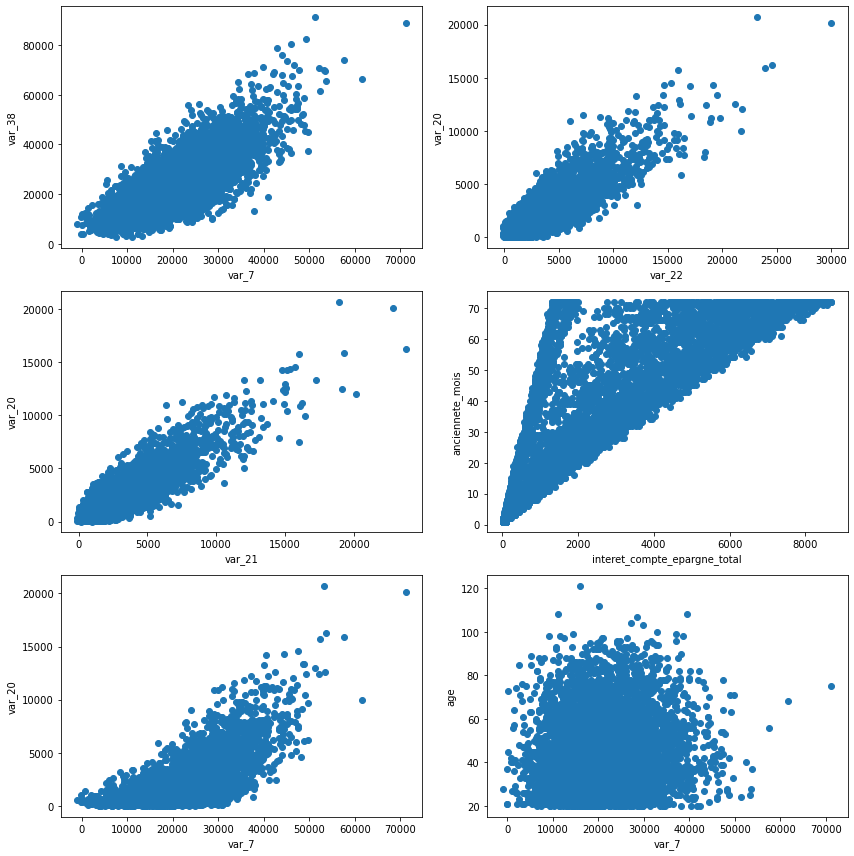

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes[0][0].scatter(df['var_7'], df['var_38'])
axes[0][0].set_xlabel('var_7')
axes[0][0].set_ylabel('var_38')

axes[0][1].scatter(df['var_22'], df['var_20'])
axes[0][1].set_xlabel('var_22')
axes[0][1].set_ylabel('var_20')

axes[1][0].scatter(df['var_21'], df['var_20'])
axes[1][0].set_xlabel('var_21')
axes[1][0].set_ylabel('var_20')


axes[1][1].scatter(df['interet_compte_epargne_total'], df['anciennete_mois'])
axes[1][1].set_xlabel('interet_compte_epargne_total')
axes[1][1].set_ylabel('anciennete_mois')


axes[2][0].scatter(df['var_7'], df['var_20'])
axes[2][0].set_xlabel('var_7')
axes[2][0].set_ylabel('var_20')

axes[2][1].scatter(df['var_7'], df['age'])
axes[2][1].set_xlabel('var_7')
axes[2][1].set_ylabel('age')

plt.tight_layout()
plt.show()

In [44]:
to_delete.append('interet_compte_epargne_total')
to_delete.append('var_38')
to_delete.append('var_21')
to_delete.append('var_22')
to_delete.append('var_20')

<AxesSubplot:>

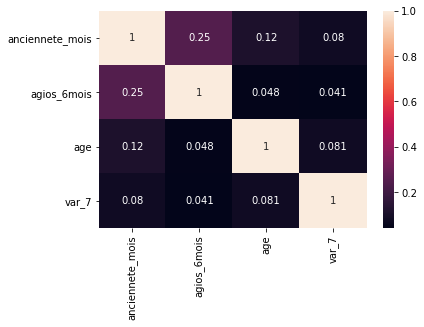

In [45]:
sns.heatmap(df[continuous_features].drop(to_delete, axis=1).corr().abs(), annot=True)
### les variables maintenues 

In [46]:
### vérifions que les variables var_x sont bien fortement corrélées avec la var_7.
corr_matrix.iloc[:,11]

anciennete_mois                 0.079932
agios_6mois                     0.040901
interet_compte_epargne_total    0.039493
age                             0.081089
var_0                           0.738923
var_1                           0.780291
var_2                           0.821927
var_3                           0.861065
var_4                           0.897759
var_5                           0.933068
var_6                           0.967219
var_7                           1.000000
var_8                           0.968351
var_9                           0.937786
var_10                          0.911909
var_11                          0.888518
var_12                          0.864724
var_13                          0.843405
var_14                          0.826975
var_15                          0.811126
var_16                          0.792949
var_17                          0.776149
var_18                          0.762039
var_19                          0.748562
var_20          

### Analyse: 
* toutes les variables var_x sont fortement corrélées avec var_7

In [47]:
selected_continuous_variables = df[continuous_features].drop(to_delete, axis=1)
selected_continuous_variables

,anciennete_mois,agios_6mois,age,var_7
0,37.0,91.15,30.0,21216.423900
1,72.0,24.10,53.0,27392.121666
2,3.0,73.60,41.0,NaN
3,72.0,112.90,44.0,17315.324866
4,4.0,70.40,32.0,16295.563660
...,...,...,...,...
7038,35.0,60.55,54.0,13745.964886
7039,19.0,89.35,43.0,26202.676474
7040,71.0,97.65,65.0,17527.480404
7041,58.0,106.45,66.0,14626.455024


In [48]:
### visualiser les valeurs manquantes. 
selected_continuous_variables[(selected_continuous_variables.isnull()['var_7'] == True) & (selected_continuous_variables.isnull()['age'] == True)]

,anciennete_mois,agios_6mois,age,var_7
900,5.0,85.20,NaN,NaN
3337,72.0,19.80,NaN,NaN
4758,28.0,90.45,NaN,NaN
5422,24.0,58.35,NaN,NaN


In [49]:
### Associer au valeures des variables catégorielles la catégorie inconnu. 
filled_na_categorical_variables = df[categorical_features].fillna('inconnu')
filled_na_categorical_variables.isnull().sum()

genre                   0
espace_client_web       0
assurance_vie           0
banque_principale       0
compte_epargne          0
credit_autres           0
cartes_bancaires        0
compte_courant          0
espace_client           0
PEA                     0
assurance_auto          0
assurance_habitation    0
credit_immo             0
type                    0
compte_titres           0
methode_contact         0
segment_client          0
branche                 0
churn                   0
dtype: int64

In [50]:
knn_imputation_df = pd.concat((filled_na_categorical_variables, selected_continuous_variables), axis =1)
knn_imputation_df.dropna(inplace=True)

In [51]:
knn_imputation_df.isnull().sum()

genre                   0
espace_client_web       0
assurance_vie           0
banque_principale       0
compte_epargne          0
credit_autres           0
cartes_bancaires        0
compte_courant          0
espace_client           0
PEA                     0
assurance_auto          0
assurance_habitation    0
credit_immo             0
type                    0
compte_titres           0
methode_contact         0
segment_client          0
branche                 0
churn                   0
anciennete_mois         0
agios_6mois             0
age                     0
var_7                   0
dtype: int64

In [52]:
### Nous allons maintenant utiliser KNN pour imputer les valueurs manquantes des variables continues

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoded_cat_var = encoder.fit_transform(knn_imputation_df[categorical_features]).toarray()

encoded_cat_var

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.]])

- Nous allons utiliser 4 modèles KNN pour prédire les valeurs manquantes des 4 variables continues. 

In [53]:
y_var_7 = knn_imputation_df['var_7']
y_age = knn_imputation_df['age']
y_agios_6mois = knn_imputation_df['agios_6mois']
y_anciennete_mois = knn_imputation_df['anciennete_mois']

x_train_var_7, x_test_var_7, y_train_var_7, y_test_var_7 = train_test_split(encoded_cat_var, y_var_7, test_size = 0.2, random_state = 49)
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(encoded_cat_var, y_age, test_size = 0.2, random_state = 49)
x_train_agios_6mois, x_test_agios_6mois, y_train_agios_6mois, y_test_agios_6mois = train_test_split(encoded_cat_var, y_agios_6mois, test_size = 0.2, random_state = 49)
x_train_anciennete_mois, x_test_anciennete_mois, y_train_anciennete_mois, y_test_anciennete_mois = train_test_split(encoded_cat_var, y_anciennete_mois, test_size = 0.2, random_state = 49)

In [54]:
K = [3,4,5,6,7,8,9,10]

MSE_var_7 = []
MSE_age = []
MSE_agios_6mois = []
MSE_anciennete_mois = []


for k in K:
    knn_var_7 = KNeighborsRegressor(n_neighbors=k, metric='jaccard')
    knn_var_7.fit(x_train_var_7,y_train_var_7)
    mse_var_7 = mean_squared_error(y_test_var_7, knn_var_7.predict(x_test_var_7))
    MSE_var_7.append(mse_var_7)
    
    knn_age = KNeighborsRegressor(n_neighbors=k, metric='jaccard')
    knn_age.fit(x_train_age,y_train_age)
    mse_age = mean_squared_error(y_test_age, knn_age.predict(x_test_age))
    MSE_age.append(mse_age)
    
    knn_agios_6mois = KNeighborsRegressor(n_neighbors=k, metric='jaccard')
    knn_agios_6mois.fit(x_train_agios_6mois,y_train_agios_6mois )
    mse_agios_6mois= mean_squared_error(y_test_agios_6mois, knn_agios_6mois.predict(x_test_agios_6mois ))
    MSE_agios_6mois.append(mse_agios_6mois)
    
    
    knn_anciennete_mois = KNeighborsRegressor(n_neighbors=k, metric='jaccard')
    knn_anciennete_mois.fit(x_train_anciennete_mois,y_train_anciennete_mois )
    mse_anciennete_mois = mean_squared_error(y_test_anciennete_mois, knn_anciennete_mois.predict(x_test_anciennete_mois ))
    MSE_anciennete_mois.append(mse_anciennete_mois)

Text(0, 0.5, 'mse')

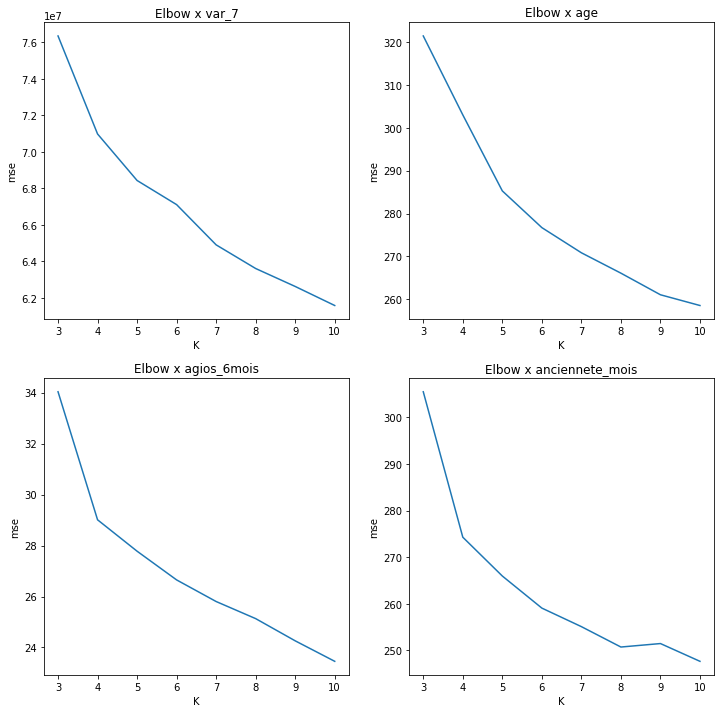

In [55]:
### On va utiliser la méthode "elbow" pour selectionner le meiller k 
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0][0].plot([3,4,5,6,7,8,9,10], MSE_var_7)
axes[0][0].set_title('Elbow x var_7')
axes[0][0].set_xlabel('K')
axes[0][0].set_ylabel('mse')

axes[0][1].plot([3,4,5,6,7,8,9,10], MSE_age)
axes[0][1].set_title('Elbow x age')
axes[0][1].set_xlabel('K')
axes[0][1].set_ylabel('mse')

axes[1][0].plot([3,4,5,6,7,8,9,10], MSE_agios_6mois)
axes[1][0].set_title('Elbow x agios_6mois')
axes[1][0].set_xlabel('K')
axes[1][0].set_ylabel('mse')

axes[1][1].plot([3,4,5,6,7,8,9,10], MSE_anciennete_mois)
axes[1][1].set_title('Elbow x anciennete_mois')
axes[1][1].set_xlabel('K')
axes[1][1].set_ylabel('mse')

In [56]:
### knn pour imputer la variable var_7
knn_var_7 = KNeighborsRegressor(n_neighbors=4, metric='jaccard')
knn_var_7.fit(x_train_var_7,y_train_var_7)
r2_var_7 = r2_score(y_test_var_7, knn_var_7.predict(x_test_var_7))
   
### knn pour imputer la variable age   
knn_age = KNeighborsRegressor(n_neighbors=5, metric='jaccard')
knn_age.fit(x_train_age,y_train_age)
r2_age = r2_score(y_test_age, knn_age.predict(x_test_age))

### knn pour imputer la variable agios_6mois
knn_agios_6mois = KNeighborsRegressor(n_neighbors=4, metric='jaccard')
knn_agios_6mois.fit(x_train_agios_6mois,y_train_agios_6mois )
r2_agios_6mois= r2_score(y_test_agios_6mois, knn_agios_6mois.predict(x_test_agios_6mois ))
 
    
### knn pour imputer la variable knn_anciennete_mois
knn_anciennete_mois = KNeighborsRegressor(n_neighbors=8, metric='jaccard')
knn_anciennete_mois.fit(x_train_anciennete_mois,y_train_anciennete_mois )
r2_anciennete_mois = r2_score(y_test_anciennete_mois, knn_anciennete_mois.predict(x_test_anciennete_mois))

print(f'r2_var_7 :{r2_var_7 }, r2_age: {r2_age}, r2_agios_6mois:{r2_agios_6mois}, r2_anciennete_mois:{r2_anciennete_mois}')

r2_var_7 :-0.1857726885713873, r2_age: -0.08380646808662151, r2_agios_6mois:0.967340560276404, r2_anciennete_mois:0.6021363832424221


### Analyse : 
* On va utiliser KNN pour imputer uniquement la variable agios_6mois car le performanc des autres KNN n'est pas au top! 

In [57]:
df_imputed_agios_6mois = pd.concat((filled_na_categorical_variables, selected_continuous_variables), axis =1)

encoder_agios_6mois = OneHotEncoder()

encoded_cat_var_agios_6mois = encoder_agios_6mois.fit_transform(df_imputed_agios_6mois[df_imputed_agios_6mois['agios_6mois'].isnull()][categorical_features]).toarray()

imputed_agios_6mois = knn_agios_6mois.predict(encoded_cat_var_agios_6mois )
imputed_agios_6mois

array([ 78.925 ,  52.7125,  44.675 ,  96.0125,  19.8375,  51.7125,
        23.575 ,  21.0125,  19.9   ,  20.2375,  24.8375,  34.7375,
        25.85  ,  55.075 ,  20.0875,  19.7875,  83.375 ,  73.    ,
        56.7125,  79.575 ,  76.8625,  83.1   ,  48.8375,  20.125 ,
        20.2375,  87.0375,  74.9375,  84.5625,  64.625 ,  24.4125,
        79.2375,  93.8375,  89.725 ,  53.3375,  78.9125, 102.4875,
        65.6   ,  20.8875,  19.6125, 103.175 ,  19.9375, 106.6375,
        19.675 ,  76.425 ,  98.9125, 102.0375,  52.5875,  79.8375,
       101.6625, 104.1   ,  66.2   ,  94.5375,  37.0625,  82.0625,
        86.1625,  19.8   ,  94.75  ,  99.4375,  74.0875,  25.3   ,
        76.1   ,  53.7   ,  74.65  ,  57.7   ,  20.3375,  77.925 ,
        99.875 , 100.05  ,  57.975 ,  70.9875, 107.225 ,  62.25  ,
        20.3   ,  21.275 ,  19.8   , 108.2875,  20.475 ,  90.75  ,
        32.0125,  86.1875,  93.0125,  20.025 ,  91.05  , 109.875 ,
        72.2375, 103.9625,  65.4125,  19.5375,  96.25  ,  92.1

In [58]:
DR_1 = df_imputed_agios_6mois[df_imputed_agios_6mois['agios_6mois'].isnull()]
DR_2 =  df_imputed_agios_6mois[~(df_imputed_agios_6mois['agios_6mois'].isnull())]
DR_1['agios_6mois'] = imputed_agios_6mois
df_imputed_agios_6mois = pd.concat((DR_1, DR_2), axis=0)
df_imputed_agios_6mois

,genre,espace_client_web,assurance_vie,banque_principale,compte_epargne,credit_autres,cartes_bancaires,compte_courant,espace_client,PEA,...,type,compte_titres,methode_contact,segment_client,branche,churn,anciennete_mois,agios_6mois,age,var_7
76,F,nan,oui,non,oui,consommation,basic,oui,oui,oui,...,inconnu,non,telephone,B2,NORD-OUEST,non,66.0,78.9250,58.0,15481.909008
123,F,0.0,non,non,non,bail,basic,inconnu,oui,oui,...,inconnu,oui,telephone,C1,NORD-OUEST,non,52.0,52.7125,35.0,17643.088096
204,H,0.0,non,non,oui,permanent,basic,non,non,non,...,pro,oui,telephone,C2,NORD-OUEST,non,7.0,44.6750,74.0,11775.264475
220,H,0.0,non,non,oui,permanent,medium,non,non,non,...,pro,oui,telephone,B1,NORD-OUEST,non,9.0,96.0125,42.0,15304.920344
251,F,0.0,non,non,oui,permanent,premium,inconnu,inconnu,inconnu,...,inconnu,non,sms,C3,inconnu,non,47.0,19.8375,63.0,33010.911733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,F,0.0,non,non,oui,permanent,basic,oui,oui,oui,...,pro,non,mail,C4,CENTRE,non,35.0,60.5500,54.0,13745.964886
7039,F,0.0,oui,oui,oui,consommation,medium,non,non,non,...,perso,oui,telephone,B1,CENTRE,non,19.0,89.3500,43.0,26202.676474
7040,H,0.0,non,non,oui,consommation,medium,oui,non,non,...,perso,non,sms,C4,OUTRE-MER,non,71.0,97.6500,65.0,17527.480404
7041,F,0.0,non,non,oui,permanent,medium,oui,oui,oui,...,perso,oui,mail,A1,SUD-OUEST,oui,58.0,106.4500,66.0,14626.455024


In [59]:
df_imputed_agios_6mois.isnull().sum()

genre                     0
espace_client_web         0
assurance_vie             0
banque_principale         0
compte_epargne            0
credit_autres             0
cartes_bancaires          0
compte_courant            0
espace_client             0
PEA                       0
assurance_auto            0
assurance_habitation      0
credit_immo               0
type                      0
compte_titres             0
methode_contact           0
segment_client            0
branche                   0
churn                     0
anciennete_mois         134
agios_6mois               0
age                     154
var_7                   136
dtype: int64

In [60]:
#### pour les autres valeurs manquantes, on va juste supprimer les lignes. 
df_imputed = df_imputed_agios_6mois.dropna()
df_imputed.isnull().sum()

genre                   0
espace_client_web       0
assurance_vie           0
banque_principale       0
compte_epargne          0
credit_autres           0
cartes_bancaires        0
compte_courant          0
espace_client           0
PEA                     0
assurance_auto          0
assurance_habitation    0
credit_immo             0
type                    0
compte_titres           0
methode_contact         0
segment_client          0
branche                 0
churn                   0
anciennete_mois         0
agios_6mois             0
age                     0
var_7                   0
dtype: int64

In [61]:
df_imputed.shape  ### les valeurs manquantes restantes ne réduisent pas beaucoup la taille du dataset. 

(6627, 23)

### Training 

In [62]:
### trouver le treshold optimal de la classification
def find_best_threshold(model, X, y, metric='f1', threshold_range=(0.1, 0.9), threshold_step=0.01):
    """
    Find the best threshold for a binary classification model.

    Parameters:
    - model: Fitted binary classification model (e.g., LogisticRegression)
    - X: Features for prediction
    - y: True labels
    - metric: Metric to optimize ('precision', 'recall', 'f1', 'roc_auc')
    - threshold_range: Tuple (min_threshold, max_threshold)
    - threshold_step: Step size for iterating through the threshold range

    Returns:
    - best_threshold: The threshold that maximizes the chosen metric
    - best_score: The score (metric) achieved at the best threshold
    """
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(threshold_range[0], threshold_range[1], threshold_step):
        y_pred_prob = model.predict_proba(X)[:, 1]         # Predicted probabilities of positive class
        y_pred = (y_pred_prob >= threshold).astype(int)

        if metric == 'precision':
            score = precision_score(y, y_pred)
        elif metric == 'recall':
            score = recall_score(y, y_pred)
        elif metric == 'f1':
            score = f1_score(y, y_pred)
        elif metric == 'accuracy':
            score = accuracy_score(y, y_pred)
        else:
            raise ValueError("Invalid metric. Choose from 'precision', 'recall', 'f1', or 'roc_auc'.")

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

### calculer les métriques d'évaluation
def calculate_classification_matrics(y_true, y_pred_hard, 
                                             y_pred_proba): 
    # Calculate accuracy
    accuracy = round(accuracy_score(y_true, y_pred_hard),2)
    
    # Calculate precision
    precision = round(precision_score(y_true, y_pred_hard),2)
    
    # Calculate recall
    recall = round(recall_score(y_true, y_pred_hard),2)

    # Calculate F1 score
    f1 = round(f1_score(y_true, y_pred_hard),2)

    # calculate roc_auc
    roc_auc = round(roc_auc_score(y_true, y_pred_proba),2)
    
    return({'Accuracy': accuracy , 'Precision': precision, 'Recall': recall, 'roc_auc':roc_auc, 'f1_Score':f1})

In [63]:
### standardization des variables continues, one hot encoding, label encoding
encoder_cat_var = OneHotEncoder() 
scaler_continuous = StandardScaler()
encoder_y = LabelEncoder()

encoded_cat_var = encoder_cat_var.fit_transform(df_imputed[categorical_features].drop('churn', axis=1)).toarray()
encoded_y = encoder_y.fit_transform(df_imputed['churn'])
scaled_continuous = scaler_continuous.fit_transform(df_imputed[['anciennete_mois','agios_6mois','age','var_7']])

In [64]:
### predictors Features 
X = np.concatenate((scaled_continuous, encoded_cat_var), axis = 1)
x_train , x_test, y_train, y_test = train_test_split(X, encoded_y , test_size =0.2, random_state=49)

In [67]:
### Logistic Regression avec régularization L1.
from sklearn.linear_model import LogisticRegression
l1 = 0.1
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=(1/l1))    ## régularization pour éviter le curse de la dimmentionnalité
lasso.fit(x_train, y_train)
train_metrics = calculate_classification_matrics(y_train, lasso.predict(x_train), lasso.predict_proba(x_train)[:,1])
test_metrics = calculate_classification_matrics(y_test, lasso.predict(x_test), lasso.predict_proba(x_test)[:,1])
metrics_report = pd.DataFrame((train_metrics, test_metrics), index = ['train_metrics', 'test_metrics'])
metrics_report

,Accuracy,Precision,Recall,roc_auc,f1_Score
train_metrics,0.88,0.83,0.69,0.93,0.75
test_metrics,0.87,0.84,0.67,0.93,0.75


### Analyse: 
* On remarque que le roc_auc est est très bon (pas d'overfitting ou d'underfitting surtout). Cela est dû au fait qu'il est indépendant du treshold choisi (0.5 par défault).  Nous allons essayer de trouver le treshold optimal afin d'améliorer la précision qui la métrique qui nous intéresse ( bonne detection des churners 1)

In [68]:
### Find the best treshold for precision
treshold = find_best_threshold(lasso, x_test, y_test, metric='precision', threshold_range=(0.1, 0.9), threshold_step=0.01)[0]
y_hard_pred = []
for e in lasso.predict_proba(x_test)[:,1]: 
    if e> treshold: 
        y_hard_pred.append(1)
    else:
        y_hard_pred.append(0)

train_metrics = calculate_classification_matrics(y_train, lasso.predict(x_train), lasso.predict_proba(x_train)[:,1])
test_metrics = calculate_classification_matrics(y_test, np.array(y_hard_pred), lasso.predict_proba(x_test)[:,1])
metrics_report = pd.DataFrame((train_metrics, test_metrics), index = ['train_metrics', 'test_metrics'])
metrics_report

,Accuracy,Precision,Recall,roc_auc,f1_Score
train_metrics,0.88,0.83,0.69,0.93,0.75
test_metrics,0.84,0.99,0.41,0.93,0.58


In [69]:
### Find the best treshold for precision
treshold = find_best_threshold(lasso, x_test, y_test, metric='f1', threshold_range=(0.1, 0.9), threshold_step=0.01)[0]
y_hard_pred = []
for e in lasso.predict_proba(x_test)[:,1]: 
    if e> treshold: 
        y_hard_pred.append(1)
    else:
        y_hard_pred.append(0)

train_metrics = calculate_classification_matrics(y_train, lasso.predict(x_train), lasso.predict_proba(x_train)[:,1])
test_metrics = calculate_classification_matrics(y_test, np.array(y_hard_pred), lasso.predict_proba(x_test)[:,1])
metrics_report = pd.DataFrame((train_metrics, test_metrics), index = ['train_metrics', 'test_metrics'])
metrics_report

,Accuracy,Precision,Recall,roc_auc,f1_Score
train_metrics,0.88,0.83,0.69,0.93,0.75
test_metrics,0.87,0.75,0.79,0.93,0.77


### Analyse: 
* Tout dépend de l'objectif métier, on peut choisir la treshold pour maximiser la performance du modèle. Si la detection des churners est avant tout, la précision est la meilleur métrique à maximiser. Si le cout de se tromper sur les non-churners est aussi élevé, dans ce cas, le Recall entre aussi en jeu et la f1 score devient le trade-off entre précision et recall.

In [70]:
### Training a Decision Tree model. 
decision_tree = DecisionTreeClassifier(min_impurity_decrease=0.007)    ### pruning pour éviter l'overfitting
decision_tree.fit(x_train, y_train)
train_metrics = calculate_classification_matrics(y_train, decision_tree.predict(x_train), decision_tree.predict_proba(x_train)[:,1])
test_metrics = calculate_classification_matrics(y_test, decision_tree.predict(x_test), decision_tree.predict_proba(x_test)[:,1])
metrics_report = pd.DataFrame((train_metrics, test_metrics), index = ['train_metrics', 'test_metrics'])
metrics_report

,Accuracy,Precision,Recall,roc_auc,f1_Score
train_metrics,0.8,0.69,0.46,0.80,0.55
test_metrics,0.8,0.71,0.46,0.81,0.56


In [71]:
### Random Forest 
random_forest = RandomForestClassifier(n_estimators=100, min_impurity_decrease=0.005, random_state=42)
random_forest.fit(x_train, y_train)
train_metrics = calculate_classification_matrics(y_train, random_forest.predict(x_train), random_forest.predict_proba(x_train)[:,1])
test_metrics = calculate_classification_matrics(y_test, random_forest.predict(x_test), random_forest.predict_proba(x_test)[:,1])
metrics_report = pd.DataFrame((train_metrics, test_metrics), index = ['train_metrics', 'test_metrics'])
metrics_report

,Accuracy,Precision,Recall,roc_auc,f1_Score
train_metrics,0.80,0.90,0.28,0.89,0.43
test_metrics,0.81,0.93,0.32,0.89,0.47


In [73]:
### XGBOOST Hyperparamters tuning 
from xgboost import XGBClassifier
param_grid = {
    'n_estimators': [50,100, 200, 300],
    'max_depth': [2,3, 4, 5]}

xgb_model = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='precision', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres : ", best_params)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs hyperparamètres :  {'max_depth': 2, 'n_estimators': 50}


In [74]:
params = {
    'n_estimators': 50,
    'max_depth': 2,
    'learning_rate':  0.1,
    'eval_metric':'logloss',
    'subsample': 0.8,
    'colsample_bytree': 0.9}

xgb_model = xgb.XGBClassifier(**params, random_state = 42)
xgb_model.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_test, y_test)],early_stopping_rounds=3, verbose=False)
train_metrics = calculate_classification_matrics(y_train, xgb_model.predict(x_train), xgb_model.predict_proba(x_train)[:,1])
test_metrics = calculate_classification_matrics(y_test, xgb_model.predict(x_test), xgb_model.predict_proba(x_test)[:,1])
metrics_report = pd.DataFrame((train_metrics, test_metrics), index = ['train_metrics', 'test_metrics'])
metrics_report

,Accuracy,Precision,Recall,roc_auc,f1_Score
train_metrics,0.87,0.85,0.63,0.92,0.72
test_metrics,0.87,0.87,0.62,0.92,0.73


In [75]:
evals_result = xgb_model.evals_result()
training_loss = evals_result['validation_0']['logloss']  
validation_loss = evals_result['validation_1']['logloss']

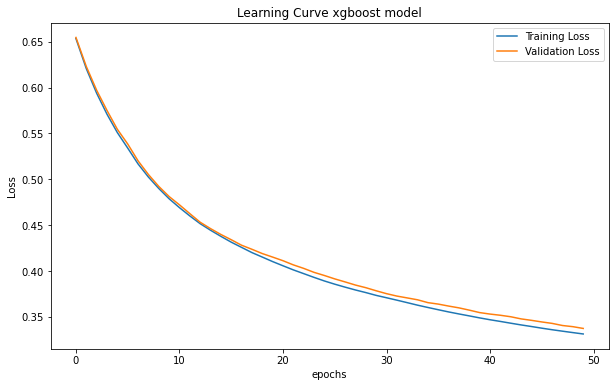

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(training_loss)), training_loss, label='Training Loss')
plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Learning Curve xgboost model')
plt.legend()
plt.show()

### Analyse: 
* le xgboost converge, stable et pas d'overfitting surtout !

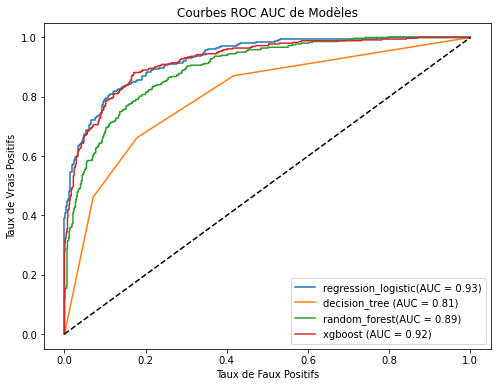

In [77]:
y_pred_regression_logistic = lasso.predict_proba(x_test)[:, 1]
y_pred_decision_tree = decision_tree.predict_proba(x_test)[:, 1]
y_pred_random_forest= random_forest.predict_proba(x_test)[:, 1]
y_pred_xgboost = xgb_model.predict_proba(x_test)[:, 1]

# Calcul des courbes ROC et des scores AUC pour chaque modèle
fpr1, tpr1, _ = roc_curve(y_test, y_pred_regression_logistic)
roc_auc1 = roc_auc_score(y_test, y_pred_regression_logistic)

fpr2, tpr2, _ = roc_curve(y_test, y_pred_decision_tree)
roc_auc2 = roc_auc_score(y_test, y_pred_decision_tree)

fpr3, tpr3, _ = roc_curve(y_test, y_pred_random_forest)
roc_auc3 = roc_auc_score(y_test, y_pred_random_forest)

fpr4, tpr4, _ = roc_curve(y_test, y_pred_xgboost)
roc_auc4 = roc_auc_score(y_test, y_pred_xgboost)

# Création du graphique
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'regression_logistic(AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'decision_tree (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, label=f'random_forest(AUC = {roc_auc3:.2f})')
plt.plot(fpr4, tpr4, label=f'xgboost (AUC = {roc_auc4:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Ligne en pointillé pour la référence
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC AUC de Modèles')
plt.legend()
plt.show()

### Xgboost vs. Regression Logistic. Qui a la meilleure précision ?

In [78]:
xgb_precsion = find_best_threshold(xgb_model, x_test, y_test, metric='precision', threshold_range=(0.1, 0.9), threshold_step=0.01)[1]
xgb_precsion

1.0

In [79]:
LogisticRegression_precsion = find_best_threshold(lasso, x_test, y_test, metric='precision', threshold_range=(0.1, 0.9), threshold_step=0.01)[0]
LogisticRegression_precsion 

0.8599999999999995

### Analyse 
* Xgboost peut-être beaucoup plus précis que la régression logistique. Ce qui veut qu'il aura une capacité supérieur de détécter les churners. 

### Interprétabilité du modèle XgBoost

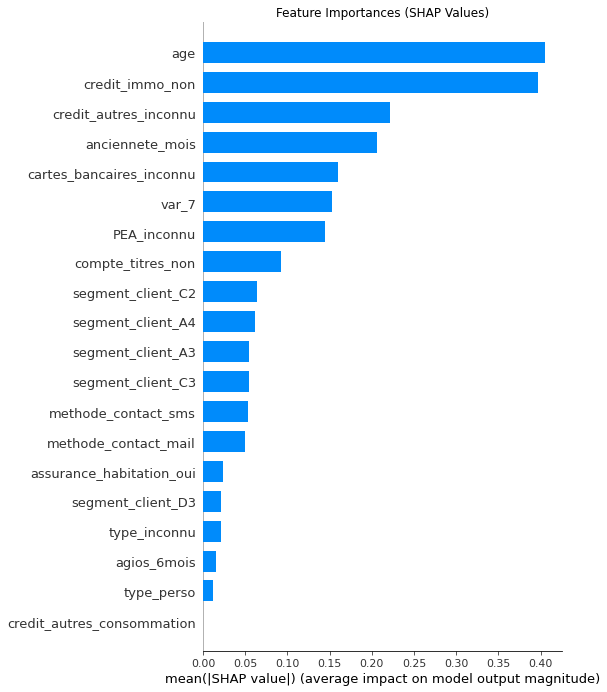

In [82]:
### Explainer of Xgboost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_train)
feature_names= np.concatenate((np.array(['anciennete_mois','agios_6mois','age','var_7']),feature_names), axis=0)
shap.summary_plot(shap_values, X,feature_names=feature_names, plot_type='bar', show=False)
plt.title('Feature Importances (SHAP Values)')
plt.show()

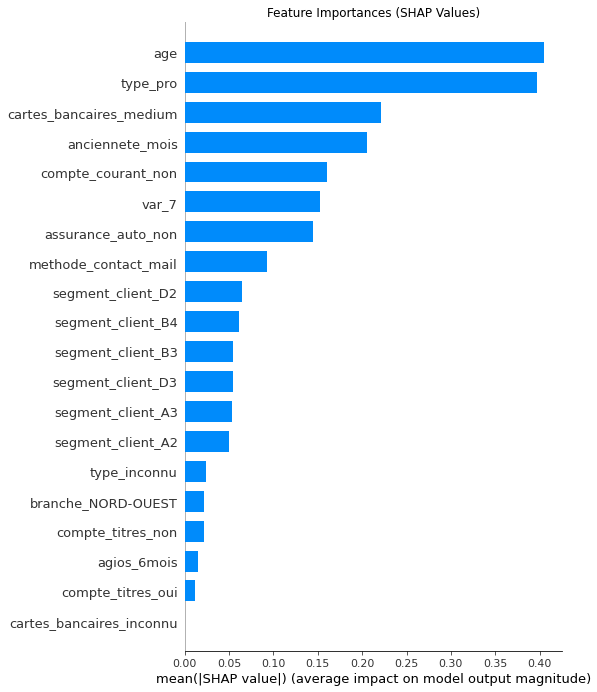

In [81]:
feature_names_encoded = encoder_cat_var.get_feature_names_out()
feature_names= np.concatenate((np.array(['anciennete_mois','agios_6mois','age','var_7']),feature_names_encoded), axis=0)
shap.summary_plot(shap_values, X,feature_names=feature_names, plot_type='bar', show=False)
plt.title('Feature Importances (SHAP Values)')
plt.show()

### Selection des variables avec PCA et leur corrélation avec la variable Churn

In [101]:
### Affichage des valeures sur la colonne var_0 afin de vérifier les inputations par la suite
var_variables[var_variables['var_0'].isnull()]

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38
68,NaN,2442.816785,5430.482283,6892.156574,10427.782447,8630.830662,11167.032656,17005.155767,18208.281583,16614.352776,...,2871.027395,5088.623508,7445.424557,6365.002873,6057.362489,5632.467418,8839.372720,8361.487498,11998.605626,11979.837484
104,NaN,8549.767254,14103.758090,NaN,15712.160172,15390.828347,18460.922339,18926.088453,19339.130173,21854.251175,...,7268.633129,10601.486609,12486.845072,12661.388007,17018.404430,17862.130975,21800.354888,22221.201864,25809.009202,27086.111950
180,NaN,16180.714174,15577.171383,15372.677516,20190.728203,22753.671385,28817.138934,32551.659484,32793.148208,33784.187509,...,15135.609958,15662.872440,17488.607126,21450.098884,22562.213225,28610.907836,32473.860350,34532.550966,38558.756103,39315.351300
206,NaN,2691.566011,8404.150595,14035.232205,17731.334710,20664.344045,22748.234047,19649.976712,20907.200369,23436.116674,...,7771.982793,6190.242644,8529.980768,8428.175157,9045.508663,10212.554096,11823.203598,19089.128223,18770.318112,17019.497106
272,NaN,10543.234562,13230.942825,13468.000255,13169.317541,13524.280446,17023.545483,21173.627432,21772.007536,22694.401557,...,9327.345684,9054.966809,10660.739165,14133.730304,14088.104214,18730.958595,20567.284940,22070.523140,24364.978209,30493.152078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6846,NaN,11887.451755,16357.266316,13567.137247,18345.122129,18995.124589,23957.144067,NaN,29033.418644,36572.421242,...,16370.884031,14816.970308,21454.650568,24737.338694,25148.696993,33112.780677,33106.966506,30770.336773,31410.765801,30941.454173
6861,NaN,5375.208248,7917.801498,6911.017842,6982.563373,9250.777612,9585.232618,13707.241396,9147.035978,10940.878801,...,1596.734887,3510.805746,6726.359774,8229.015569,9051.885930,9701.108714,10621.751516,12369.160344,13829.293726,13019.799125
6940,NaN,1069.464411,NaN,2834.807107,1766.578427,3294.524783,3688.706841,8755.403184,11545.170105,12539.895253,...,2506.924706,3805.302134,3621.632189,5490.806784,5015.195586,7508.254470,7385.437138,8784.712750,10457.226136,9803.375106
7002,NaN,11910.551974,14622.899481,17548.949014,21676.800584,24865.977681,28133.244372,27707.773254,29683.330944,31512.402234,...,11501.614946,11849.664671,12735.682502,15602.125109,15428.492866,21529.887861,23344.746272,26218.654616,25889.723788,31518.530891


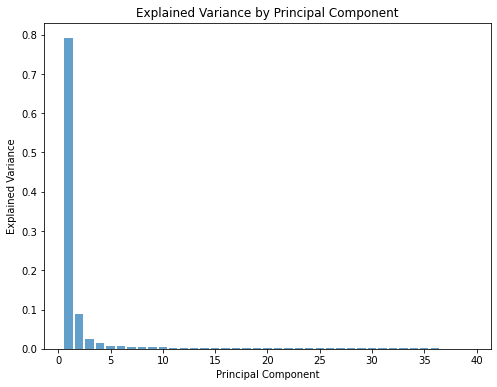

In [119]:
from sklearn.decomposition import PCA

var_variables_filledna = var_variables.fillna(var_variables.mean())    ### imputation par la moyenne avant d'appliquer la pca

### Standardization essentielle pour la pca
pca_scaler = StandardScaler()
var_variables_filledna_scaled = pca_scaler.fit_transform(var_variables_filledna)

### Apply PCA 

pca = PCA()
variables_after_pca =  pca.fit_transform(var_variables_filledna_scaled)
explained_variance = pca.explained_variance_ratio_

### plot the explained variance by principal components 
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Component')
plt.show()

In [117]:
### select the number of components to keep 
cumulative_variance = np.cumsum(explained_variance)
desired_variance = 0.90
num_components_to_keep = np.argmax(cumulative_variance >= desired_variance) + 1
print(f"Number of components to keep to explain {desired_variance*100}% variance: {num_components_to_keep}")

Number of components to keep to explain 90.0% variance: 3


### Conditions to apply pca to verify:
  * linearity between original variables and principal components: very important
  * no or weak presence of outliers: very important
  * equal or comprable variance: by standardization : very importnant
  * normality of data : use log transformation to make data look more normal : not important 
  * no multicolinearity :  there is no linear relationship between original variables nor any strong correlation: not important 
  * independant observation : very important 
  * sufficient large sample : very important 
  * continuous or ordinal variables : very important 

In [130]:
retained_variables_var_after_pca = variables_after_pca[:,0:2]   
retained_variables_var_after_pca    ### retenir deux variables explique 90% de la variance de toute les variables var_x

array([[-1.34600085,  0.98534986],
       [ 2.01630627,  1.82482313],
       [ 3.9443349 , -0.91542317],
       ...,
       [-0.17576495, -0.23004035],
       [-6.49997692,  2.79116744],
       [ 6.29171283, -2.37830684]])

In [129]:
### les variables genre, compte_epargne, credit_autres et credit_immo n'ont aucun effet sur la variable churn d'après les statistiques ci-haut
retained_categorical_variables = categorical_features.copy()
retained_categorical_variables.remove('genre')
retained_categorical_variables.remove('compte_epargne')
retained_categorical_variables.remove('credit_autres')
retained_categorical_variables.remove('credit_immo')
retained_categorical_variables    ### pas de variables ordinales 

['espace_client_web',
 'assurance_vie',
 'banque_principale',
 'cartes_bancaires',
 'compte_courant',
 'espace_client',
 'PEA',
 'assurance_auto',
 'assurance_habitation',
 'type',
 'compte_titres',
 'methode_contact',
 'segment_client',
 'branche',
 'churn']

<AxesSubplot:>

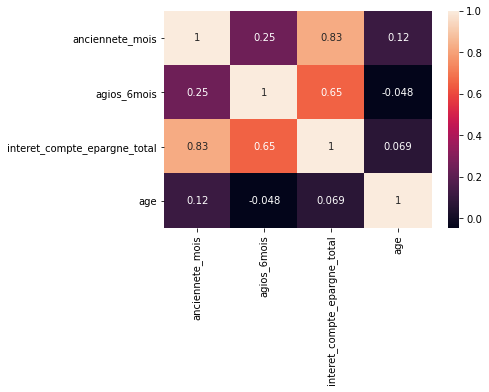

In [135]:
### feature selection using correlation matrix 
sns.heatmap(df[continuous_features[:4]].corr(), annot = True)

In [138]:
retained_continuous_features = continuous_features[:4].copy()
retained_continuous_features.remove('interet_compte_epargne_total')   ### la variable ancienneté_mois a une corrélation inférieur à interet_compte_epargne_total avec les autres variables
all_retained_features = retained_categorical_variables + retained_continuous_features 
all_retained_features   ## without pca 

['espace_client_web',
 'assurance_vie',
 'banque_principale',
 'cartes_bancaires',
 'compte_courant',
 'espace_client',
 'PEA',
 'assurance_auto',
 'assurance_habitation',
 'type',
 'compte_titres',
 'methode_contact',
 'segment_client',
 'branche',
 'churn',
 'anciennete_mois',
 'agios_6mois',
 'age']

In [139]:
imputed_cat = df[retained_categorical_variables].fillna('inconnu')   ### fillna des variables catégorielles par 'incoonu'
imputed_cat.isnull().sum()

espace_client_web       0
assurance_vie           0
banque_principale       0
cartes_bancaires        0
compte_courant          0
espace_client           0
PEA                     0
assurance_auto          0
assurance_habitation    0
type                    0
compte_titres           0
methode_contact         0
segment_client          0
branche                 0
churn                   0
dtype: int64

In [155]:
pca_df = pd.DataFrame(retained_variables_var_after_pca, columns = ['pca_1', 'pca_2'])
imputed_df_1 = pd.concat((imputed_cat,pca_df, df[retained_continuous_features]), axis = 1)
imputed_df_1 = imputed_df_1.dropna()
imputed_df_1.shape

(6617, 20)

In [196]:
### standardization des variables continues, one hot encoding, label encoding
encoder_cat_var = OneHotEncoder() 
scaler_continuous = StandardScaler()
encoder_y = LabelEncoder()

encoded_cat_var = encoder_cat_var.fit_transform(imputed_df_1[retained_categorical_variables].drop('churn', axis=1)).toarray()
encoded_y = encoder_y.fit_transform(imputed_df_1['churn'])
scaled_continuous = scaler_continuous.fit_transform(imputed_df_1[['anciennete_mois','agios_6mois','age','pca_1', 'pca_2']])

X = np.concatenate((scaled_continuous, encoded_cat_var), axis = 1)
x_train , x_test, y_train, y_test = train_test_split(X, encoded_y , test_size =0.3, random_state=49)

In [197]:
l1 = 0.1
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=(1/l1))    ## régularization pour éviter le curse de la dimmentionnalité
lasso.fit(x_train, y_train)
train_metrics = calculate_classification_matrics(y_train, lasso.predict(x_train), lasso.predict_proba(x_train)[:,1])
test_metrics = calculate_classification_matrics(y_test, lasso.predict(x_test), lasso.predict_proba(x_test)[:,1])
metrics_report = pd.DataFrame((train_metrics, test_metrics), index = ['train_metrics', 'test_metrics'])
metrics_report

,Accuracy,Precision,Recall,roc_auc,f1_Score
train_metrics,0.89,0.84,0.71,0.94,0.77
test_metrics,0.88,0.79,0.71,0.93,0.75


In [198]:
### Random Forest 
random_forest = RandomForestClassifier(n_estimators=100, min_impurity_decrease=0.005, random_state=42)
random_forest.fit(x_train, y_train)
train_metrics = calculate_classification_matrics(y_train, random_forest.predict(x_train), random_forest.predict_proba(x_train)[:,1])
test_metrics = calculate_classification_matrics(y_test, random_forest.predict(x_test), random_forest.predict_proba(x_test)[:,1])
metrics_report = pd.DataFrame((train_metrics, test_metrics), index = ['train_metrics', 'test_metrics'])
metrics_report

,Accuracy,Precision,Recall,roc_auc,f1_Score
train_metrics,0.82,0.90,0.36,0.89,0.52
test_metrics,0.82,0.88,0.37,0.89,0.52


In [206]:
params = {
    'n_estimators': 50,
    'max_depth': 3,
    'learning_rate':  0.1,
    'eval_metric':'logloss',
    'subsample': 0.8,
    'colsample_bytree': 0.9}

xgb_model = xgb.XGBClassifier(**params, random_state = 42)
xgb_model.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_test, y_test)],early_stopping_rounds=2, verbose=False)
train_metrics = calculate_classification_matrics(y_train, xgb_model.predict(x_train), xgb_model.predict_proba(x_train)[:,1])
test_metrics = calculate_classification_matrics(y_test, xgb_model.predict(x_test), xgb_model.predict_proba(x_test)[:,1])
metrics_report = pd.DataFrame((train_metrics, test_metrics), index = ['train_metrics', 'test_metrics'])
metrics_report

,Accuracy,Precision,Recall,roc_auc,f1_Score
train_metrics,0.89,0.86,0.69,0.94,0.77
test_metrics,0.88,0.81,0.68,0.93,0.74


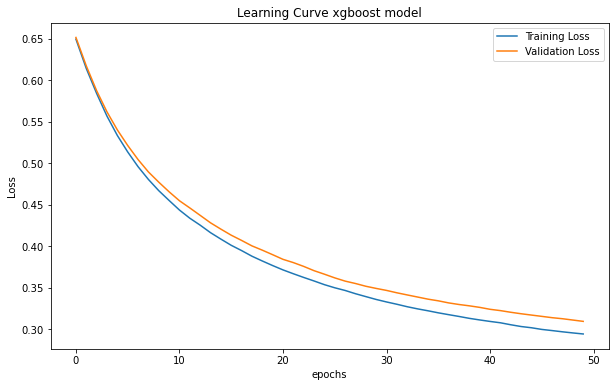

In [207]:
evals_result = xgb_model.evals_result()
training_loss = evals_result['validation_0']['logloss']  
validation_loss = evals_result['validation_1']['logloss']

plt.figure(figsize=(10, 6))
plt.plot(range(len(training_loss)), training_loss, label='Training Loss')
plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Learning Curve xgboost model')
plt.legend()
plt.show()

### Analyse des Résultats
un overfitting léger à cause des outliers  